# Introduction

This notebook replicates the procedures taken to analyse the data and produce the graphs for the ARAUS dataset paper. Sections with top-level headers may be run individually, or you may run the notebook from start to finish as well. The sections with top-level headers are:

# Section 3.3: Replicate fold allocation for soundscapes

## Import relevant packages

In [1]:
import sklearn.decomposition
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from araus_utils import SOM, assign_clusters, assign_folds

normalise = lambda X: (X-np.mean(X,axis=0,keepdims=True))/np.std(X,axis=0,keepdims=True) # Normalise an (n,p) numpy array to mean 0, variance 1.

## Load data file for soundscapes

In [2]:
soundscapes = pd.read_csv(os.path.join('..','data','soundscapes.csv'))

## Extract relevant data

Extract only the relevant soundscapes (120 Urban Soundscapes of the World recordings) and drop irrelevant (psycho)acoustic parameter columns. The irrelevant columns are argmins and argmaxes because they don't provide useful information for the PCA (heuristically speaking, they're just times in seconds when the maximum values occurred). The relevant data is stored in `soundscapes_relevant`.

In [3]:
relevant_columns = ['soundscape','fold_s','insitu_leq','gain_s',
                    'Savg_s','Smax_s','S05_s','S10_s','S20_s','S30_s','S40_s','S50_s','S60_s','S70_s','S80_s','S90_s','S95_s',
                    'Navg_s','Nrmc_s','Nmax_s','N05_s','N10_s','N20_s','N30_s','N40_s','N50_s','N60_s','N70_s','N80_s','N90_s','N95_s',
                    'Favg_s','Fmax_s','F05_s','F10_s','F20_s','F30_s','F40_s','F50_s','F60_s','F70_s','F80_s','F90_s','F95_s',
                    'LAavg_s','LAmin_s','LAmax_s','LA05_s','LA10_s','LA20_s','LA30_s','LA40_s','LA50_s','LA60_s','LA70_s','LA80_s','LA90_s','LA95_s',
                    'LCavg_s','LCmin_s','LCmax_s','LC05_s','LC10_s','LC20_s','LC30_s','LC40_s','LC50_s','LC60_s','LC70_s','LC80_s','LC90_s','LC95_s',
                    'Ravg_s','Rmax_s','R05_s','R10_s','R20_s','R30_s','R40_s','R50_s','R60_s','R70_s','R80_s','R90_s','R95_s',
                    'Tgavg_s','Tavg_s','Tmax_s','T05_s','T10_s','T20_s','T30_s','T40_s','T50_s','T60_s','T70_s','T80_s','T90_s','T95_s',
                    'M00005_0_s','M00006_3_s','M00008_0_s','M00010_0_s','M00012_5_s','M00016_0_s','M00020_0_s','M00025_0_s','M00031_5_s','M00040_0_s',
                    'M00050_0_s','M00063_0_s','M00080_0_s','M00100_0_s','M00125_0_s','M00160_0_s','M00200_0_s','M00250_0_s','M00315_0_s','M00400_0_s',
                    'M00500_0_s','M00630_0_s','M00800_0_s','M01000_0_s','M01250_0_s','M01600_0_s','M02000_0_s','M02500_0_s','M03150_0_s','M04000_0_s',
                    'M05000_0_s','M06300_0_s','M08000_0_s','M10000_0_s','M12500_0_s','M16000_0_s','M20000_0_s']

In [4]:
soundscapes_relevant = soundscapes[soundscapes['fold_s'] != 0].drop(columns = ['Sargmax_s','Nargmax_s','Fargmax_s','LAargmin_s','LAargmax_s','LCargmin_s','LCargmax_s','Rargmax_s','Targmax_s'])
soundscapes_relevant

,soundscape,fold_s,insitu_leq,gain_s,Savg_s,Smax_s,S05_s,S10_s,S20_s,S30_s,...,M02500_0_s,M03150_0_s,M04000_0_s,M05000_0_s,M06300_0_s,M08000_0_s,M10000_0_s,M12500_0_s,M16000_0_s,M20000_0_s
0,R0001_segment_binaural_44100_1.wav,2,65.666663,0.759272,1.820,1.99,1.90,1.88,1.86,1.85,...,47.06,50.20,49.81,48.02,45.36,45.25,43.30,44.91,38.50,30.57
1,R0001_segment_binaural_44100_2.wav,2,65.323993,0.759272,1.780,1.93,1.85,1.84,1.82,1.80,...,46.91,49.64,49.44,47.85,45.34,45.16,43.20,44.94,38.35,30.56
2,R0002_segment_binaural_44100_1.wav,4,68.120611,1.363361,1.290,1.59,1.41,1.37,1.35,1.32,...,46.13,49.26,48.40,43.54,39.92,38.98,35.31,35.74,28.59,15.38
3,R0002_segment_binaural_44100_2.wav,4,66.948191,1.363361,1.280,1.76,1.42,1.40,1.38,1.36,...,43.05,45.14,44.78,40.50,37.81,37.54,33.95,32.11,23.97,14.36
4,R0003_segment_binaural_44100_1.wav,4,56.315793,1.114716,1.120,1.60,1.42,1.35,1.26,1.22,...,37.01,36.34,35.86,31.91,29.75,28.35,26.47,23.69,17.88,10.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,R0131_segment_binaural_44100_2.wav,4,64.697878,1.035196,1.020,1.28,1.13,1.11,1.07,1.04,...,43.06,37.70,35.29,28.91,27.37,26.44,23.55,25.41,17.44,10.81
237,R0132_segment_binaural_44100_1.wav,3,62.048053,1.152047,1.100,1.36,1.21,1.19,1.16,1.14,...,37.78,37.03,37.43,32.65,31.19,27.68,28.89,25.13,19.08,11.89
238,R0132_segment_binaural_44100_2.wav,3,55.134026,1.152047,1.030,1.30,1.15,1.11,1.08,1.06,...,31.63,29.98,29.22,24.91,22.11,21.17,22.29,18.51,14.53,10.23
239,R0133_segment_binaural_44100_1.wav,2,63.662234,1.241129,0.981,1.17,1.06,1.04,1.03,1.01,...,40.09,37.78,35.42,30.42,28.73,28.24,24.96,20.76,20.08,10.97


In [5]:
soundscapes_relevant = soundscapes_relevant.join(soundscapes_relevant['soundscape'].str.extract('(.*?)_.*_.*_.*_(.*?).wav').rename(columns={0:'video',1:'half'}))
soundscapes_relevant_1 = soundscapes_relevant[soundscapes_relevant['half'] == '1'].set_index('video')
soundscapes_relevant_2 = soundscapes_relevant[soundscapes_relevant['half'] == '2'].set_index('video')
soundscapes_relevant = soundscapes_relevant_1.join(soundscapes_relevant_2, how = 'right', lsuffix = '_1', rsuffix = '_2')

Convert the psychoacoustic indicator part of `soundscapes_relevant` (i.e. columns 4 to 135 and columns 141 to the second last column (all indices are inclusive here)) to a feature matrix (i.e. raw data) for PCA in a numpy array `Xs`. We will perform PCA followed by clustering on `Xs`.

In [6]:
Xs = np.concatenate((soundscapes_relevant.iloc[:,4:136].values,soundscapes_relevant.iloc[:,141:-1].values),axis=-1)

## Perform PCA

Normalise the feature matrix (to get `Xs_norm`).

In [7]:
Xs_norm  = normalise(Xs) # (120, 264), normalised soundscape features

Perform PCA on the normalised feature matrix. We use `sklearn.decomposition.PCA` to perform the PCA via singular value decomposition of the sample covariance matrix, and get the following outputs of the PCA:
- `Us` : The principal components matrix
- `Ls_norm` : Percentages of variance explained by each eigenvalue, in decreasing order
- `Ys` : The PCA-transformed data matrix

In [8]:
Xs_PCA = sklearn.decomposition.PCA().fit(Xs_norm)
Us, Ls_norm, Ys = Xs_PCA.components_, Xs_PCA.explained_variance_ratio_, Xs_PCA.transform(Xs_norm)

Calculate the number of components to keep to explain at least `desired_explained_variance` of the total variance. For the generation of the dataset, we want the components to explain at least 90% of the variance.

In [9]:
n_components = np.sum(np.cumsum(Ls_norm) < 0.9)

print(f'To keep first {n_components} components if we want to explain 90% of the variance.')

To keep first 9 components if we want to explain 90% of the variance.


Expected output of the above block:
```
To keep first 9 components if we want to explain 90% of the variance.
```

Extract out first `n_components` principal components (i.e. those that explain 90% of the variance) as a truncated PCA-transformed data matrix `Ys`. These will be used for SOM clustering later.

In [10]:
Ys = Ys[:,:n_components]

As a visualisation of the importance of the weights, we plot the absolute values of the principal components for the soundscapes as heatmaps.

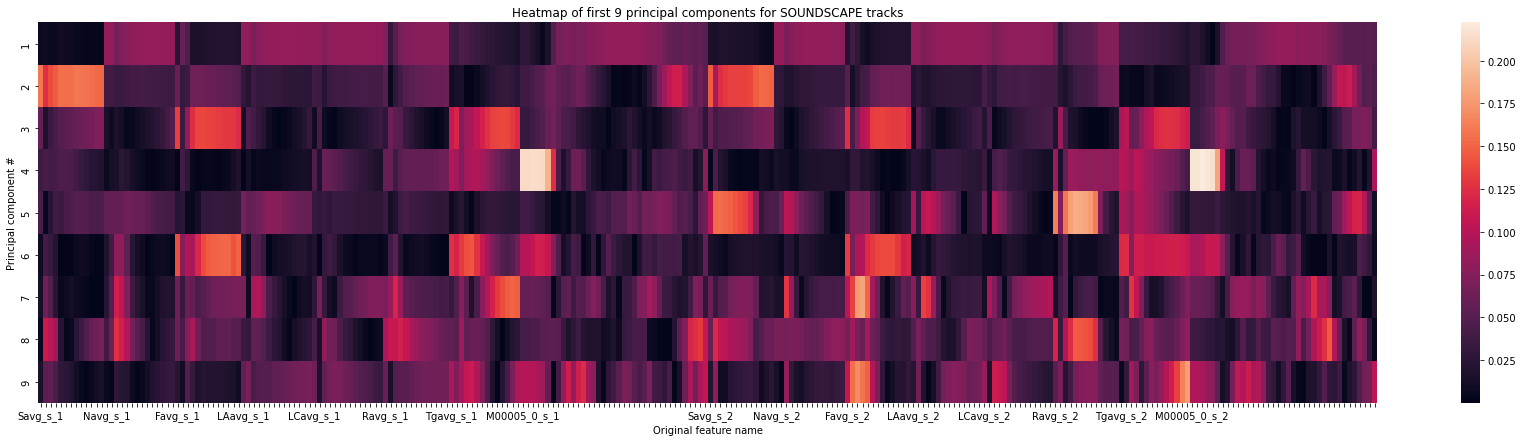

In [11]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = 'normal'

xticklabels_s = np.concatenate((soundscapes_relevant.iloc[:,4:136].columns.values,soundscapes_relevant.iloc[:,141:-1].columns.values)).tolist()
for idx, string in enumerate(xticklabels_s):
    if string not in ['Savg_s_1','Navg_s_1','Favg_s_1','LAavg_s_1','LCavg_s_1','Ravg_s_1','Tgavg_s_1','M00005_0_s_1',
                      'Savg_s_2','Navg_s_2','Favg_s_2','LAavg_s_2','LCavg_s_2','Ravg_s_2','Tgavg_s_2','M00005_0_s_2']:
        xticklabels_s[idx] = ''

yticklabels_s = np.arange(1,n_components+1)
plt.figure(figsize=(30,7))
plt.title(f'Heatmap of first {n_components} principal components for SOUNDSCAPE tracks')
sns.heatmap(np.abs(Us[:n_components,:]),xticklabels=xticklabels_s,yticklabels=yticklabels_s)
plt.xlabel('Original feature name')
plt.ylabel('Principal component #')
plt.show()

Expected output of the above block:

<img src="../figures/SOUNDSCAPE_abs.png" height="3000" width="700">

## Perform SOM clustering

We apply the SOM clustering (here, `SOM` is a helper function that performs the clustering for us) on the truncated PCA-transformed data matrix `Ys` (9 components) to obtain the cluster centres `Ws`. Note that `Ds` is the distance matrix from the cluster centres to the individual points in the truncated PCA-transformed data matrix.

(On an Intel i5-5257U CPU @ 2.70 GHz with 8GB of RAM, the next block took about 2.5 seconds to run.)

In [12]:
Ds, Ws = SOM(data = Ys, n1 = 120//5, n2 = 1, eta_SO = 1, eta_Conv = 0.1, seed_val = 2021, verbose = False)

We visualise the SOM clustering result by plotting the first two principal components of each track and cluster centre on a 2D plot (we haven't sorted the tracks into the actual clusters yet; the plots of the sorted tracks can be found <a href='#Final-plots-s'> below</a>). <a name='Unclustered-plots-s'>

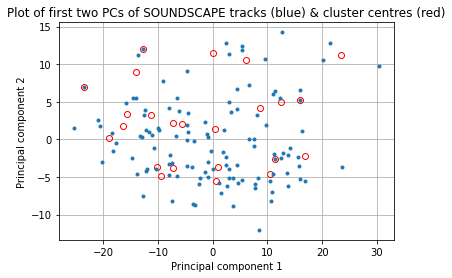

In [13]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = 'normal'

plt.figure()
plt.title(f'Plot of first two PCs of SOUNDSCAPE tracks (blue) & cluster centres (red)')
plt.plot(Ws[:,0],Ws[:,1],'ro',fillstyle='none') # Plot first two principal components of cluster prototype
plt.plot(Ys[:,0],Ys[:,1],'.') # Plot first two principal components of each transformed feature matrix
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.grid(which='both',axis='both')
plt.show()

Expected output of the above block:

<img src="../figures/SOUNDSCAPE_pc.png">

Assign the tracks into the actual clusters by their distance to the cluster centres. The `Cs` array returned by `assign_clusters` contains the indices of the clusters for each track.

In [14]:
Cs = assign_clusters(Ds, Ws, m=5)

Given the cluster indices, randomly assign each track in a cluster to one of the five folds of the cross-validation set. The `Fs` array returned by `assign_folds` contains the indices of the folds for each track.

In [15]:
Fs = assign_folds(Cs)

Plot the first two principal components of each track with a different marker style for each fold. <a name='Final-plots-s'>
   
These are the exact same plots as <a href='#Unclustered-plots-s'> here</a>.

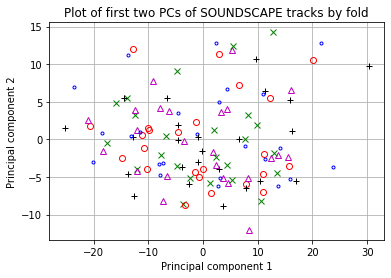

In [16]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = 'normal'

fstrings = ['b.','ro','k+','gx','m^'] # Each string corresponds to a label type for each fold.

plt.figure()
plt.title(f'Plot of first two PCs of SOUNDSCAPE tracks by fold')
for idx, fold in enumerate(Fs):
    plt.plot(Ys[idx,0],Ys[idx,1],fstrings[fold-1], fillstyle='none') # Plot first two principal components of each transformed feature matrix
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.grid(which='both',axis='both')
plt.show()

The graph generated should be identical to the following:

<img src="../figures/SOUNDSCAPE_fold.png">

Verify that the final folds outputted by the SOM clustering match the fold numbers for the individual soundscapes in the dataset exactly.

In [17]:
np.all(soundscapes_relevant[['fold_s_1','fold_s_2']].max(axis=1).values == Fs)

True

Expected output of the above block:
```
True
```

Note that we never accessed `soundscapes_relevant[['fold_s_1','fold_s_2']]` to perform the PCA or SOM clustering, so the values in `Fs` were indeed indepdently derived from the PCA and SOM clustering.

# Section 3.3: Replicate fold allocation for maskers

## Import relevant packages

In [18]:
import sklearn.decomposition
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from araus_utils import SOM, assign_clusters, assign_folds

normalise = lambda X: (X-np.mean(X,axis=0,keepdims=True))/np.std(X,axis=0,keepdims=True) # Normalise an (n,p) numpy array to mean 0, variance 1.

## Load data file for maskers

In [19]:
maskers = pd.read_csv(os.path.join('..','data','maskers.csv'))

## Extract relevant data

Extract only the relevant maskers (280 Freesound/xeno-canto ones) and drop irrelevant (psycho)acoustic parameter columns. The irrelevant columns are argmins and argmaxes because they don't provide useful information for the PCA (heuristically speaking, they're just times in seconds when the maximum values occurred).

In [20]:
maskers_relevant = maskers[(maskers['fold_m'] > 0) & (~maskers['masker'].str.match('silence'))].drop(columns = ['Sargmax_m','Nargmax_m','Fargmax_m','LAargmin_m','LAargmax_m','LCargmin_m','LCargmax_m','Rargmax_m','Targmax_m']) 
maskers_bird = maskers_relevant[maskers_relevant['class'] == 'bird']
maskers_construction = maskers_relevant[maskers_relevant['class'] == 'construction']
maskers_traffic = maskers_relevant[maskers_relevant['class'] == 'traffic']
maskers_water = maskers_relevant[maskers_relevant['class'] == 'water']
maskers_wind = maskers_relevant[maskers_relevant['class'] == 'wind']

Convert the psychoacoustic indicator part of the respective dataframes (i.e. columns 84 onwards) to feature matrices (i.e. raw data) for PCA (these are the arrays `Xb`, `Xc`, `Xt`, `Xwa`, `Xwi` in the next block). We will perform PCA followed by clustering on each class of masker SEPARATELY.

In [21]:
Xb  = maskers_bird.iloc[:,84:].values
Xc  = maskers_construction.iloc[:,84:].values
Xt  = maskers_traffic.iloc[:,84:].values
Xwa = maskers_water.iloc[:,84:].values
Xwi = maskers_wind.iloc[:,84:].values

## Perform PCA

Normalise the feature matrices (to get the arrays `Xb_norm`, `Xc_norm`, `Xt_norm`, `Xwa_norm`, `Xwi_norm` in the next block).

In [22]:
Xb_norm  = normalise(Xb ) # (80, 132), normalised bird masker features
Xc_norm  = normalise(Xc ) # (40, 132), normalised construction masker features
Xt_norm  = normalise(Xt ) # (40, 132), normalised traffic masker features
Xwa_norm = normalise(Xwa) # (80, 132), normalised water masker features
Xwi_norm = normalise(Xwi) # (40, 132), normalised wind masker features

Perform PCA on the normalised feature matrices. We use `sklearn.decomposition.PCA` to perform the PCA via singular value decomposition of the sample covariance matrix, and get the following outputs of the PCA:
- `Ub`, `Uc`, `Ut`, `Uwa`, `Uwi` : The principal components matrices
- `Lb_norm`, `Lc_norm`, `Lt_norm`, `Lwa_norm`, `Lwi_norm` : Percentages of variance explained by each eigenvalue, in decreasing order
- `Yb`, `Yc`, `Yt`, `Ywa`, `Ywi` : The PCA-transformed data matrices

In [23]:
Xb_PCA  = sklearn.decomposition.PCA().fit(Xb_norm )
Xc_PCA  = sklearn.decomposition.PCA().fit(Xc_norm )
Xt_PCA  = sklearn.decomposition.PCA().fit(Xt_norm )
Xwa_PCA = sklearn.decomposition.PCA().fit(Xwa_norm)
Xwi_PCA = sklearn.decomposition.PCA().fit(Xwi_norm)

Ub , Lb_norm , Yb  = Xb_PCA.components_ , Xb_PCA.explained_variance_ratio_ , Xb_PCA.transform(Xb_norm)
Uc , Lc_norm , Yc  = Xc_PCA.components_ , Xc_PCA.explained_variance_ratio_ , Xc_PCA.transform(Xc_norm)
Ut , Lt_norm , Yt  = Xt_PCA.components_ , Xt_PCA.explained_variance_ratio_ , Xt_PCA.transform(Xt_norm)
Uwa, Lwa_norm, Ywa = Xwa_PCA.components_, Xwa_PCA.explained_variance_ratio_, Xwa_PCA.transform(Xwa_norm)
Uwi, Lwi_norm, Ywi = Xwi_PCA.components_, Xwi_PCA.explained_variance_ratio_, Xwi_PCA.transform(Xwi_norm)

Calculate the number of components to keep to explain at least `desired_explained_variance` of the total variance. For the generation of the dataset, we want the components to explain at least 90% of the variance.

In [24]:
n_components = [np.sum(np.cumsum(L) < 0.9) for L in [Lb_norm, Lc_norm, Lt_norm, Lwa_norm, Lwi_norm]]

print(f'To keep first {n_components} components if we want to explain 90% of the variance.')

To keep first [13, 9, 8, 8, 6] components if we want to explain 90% of the variance.


Expected output of the above block:
```
To keep first [13, 9, 8, 8, 6] components if we want to explain 90% of the variance.
```

Extract out first `n_components` principal components (i.e. those that explain 90% of the variance) as truncated PCA-transformed data matrices (the arrays `Yb`, `Yc`, `Yt`, `Ywa`, `Ywi`). These will be used for SOM clustering later.

In [25]:
Yb  =  Yb[:,:n_components[0]]
Yc  =  Yc[:,:n_components[1]]
Yt  =  Yt[:,:n_components[2]]
Ywa = Ywa[:,:n_components[3]]
Ywi = Ywi[:,:n_components[4]]

As a visualisation of the importance of the weights, we plot the absolute values of the principal components for each masker class (separated into bird, construction, traffic, water, wind) as heatmaps.

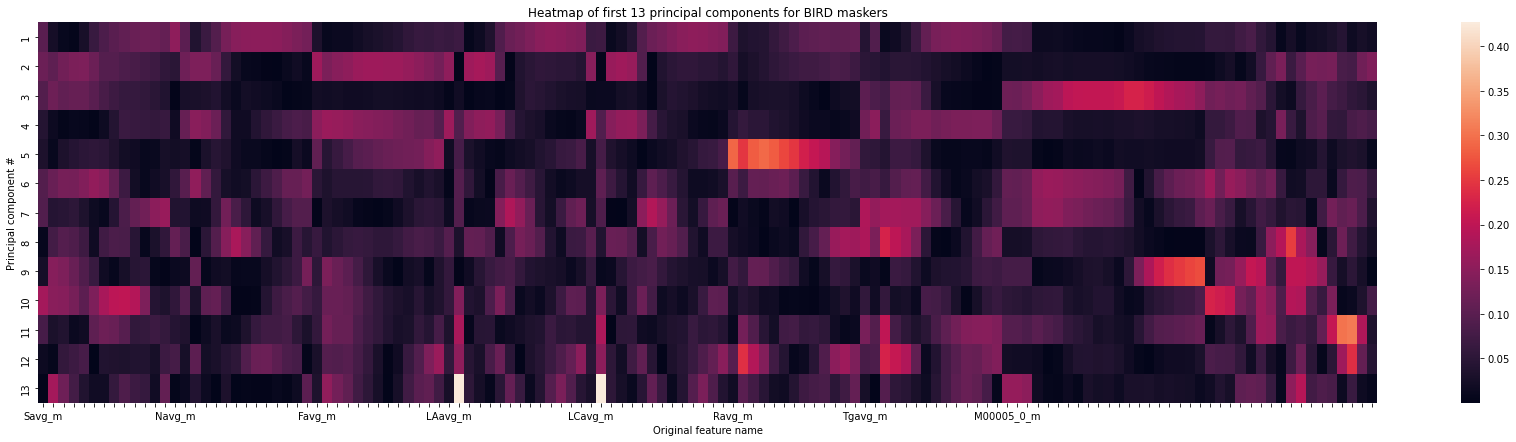

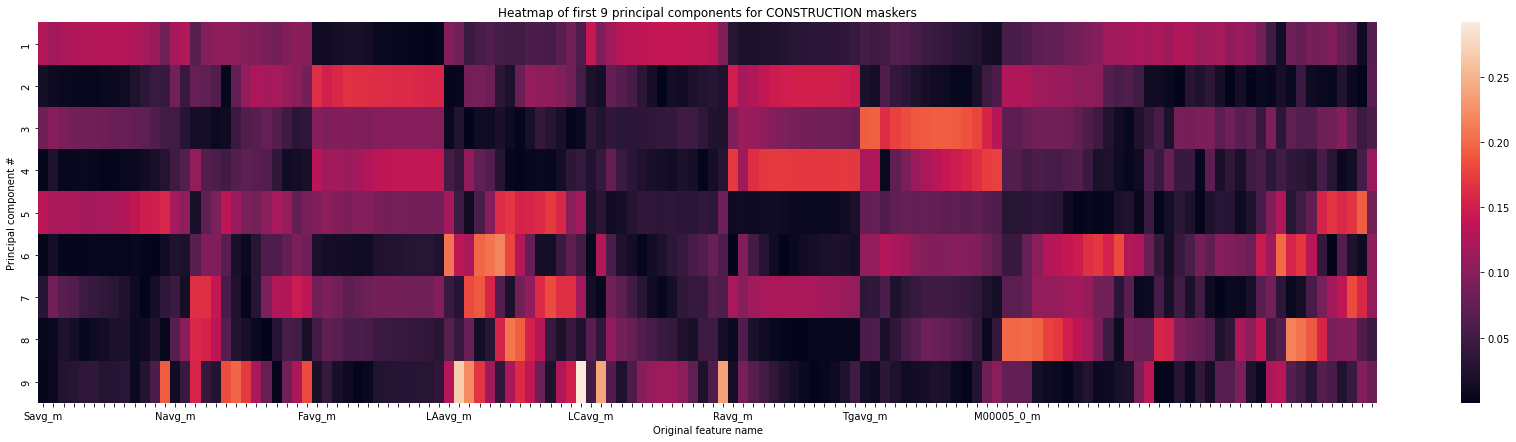

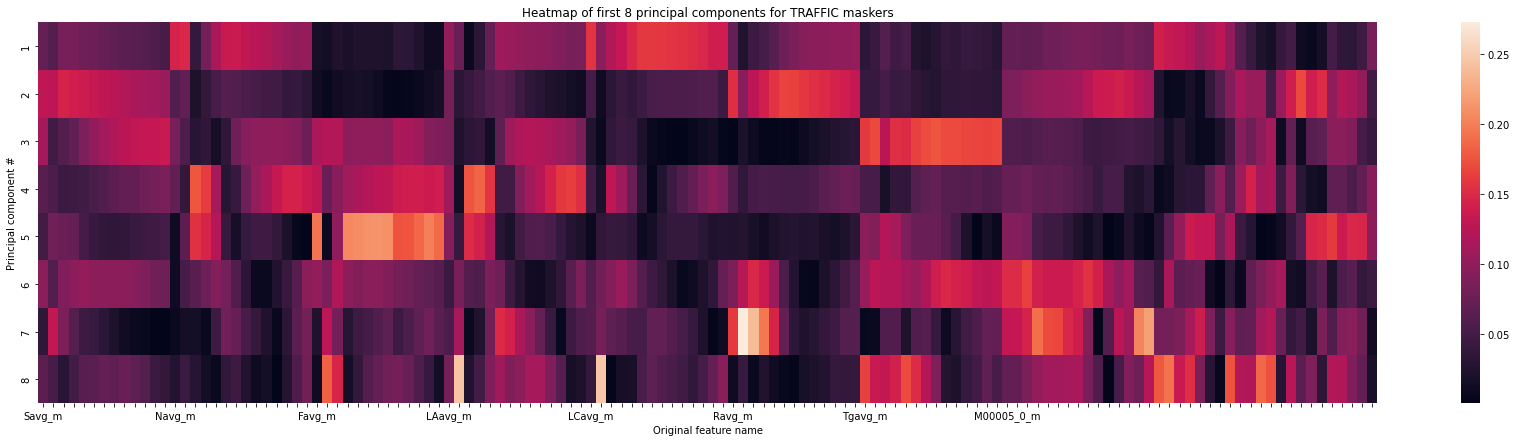

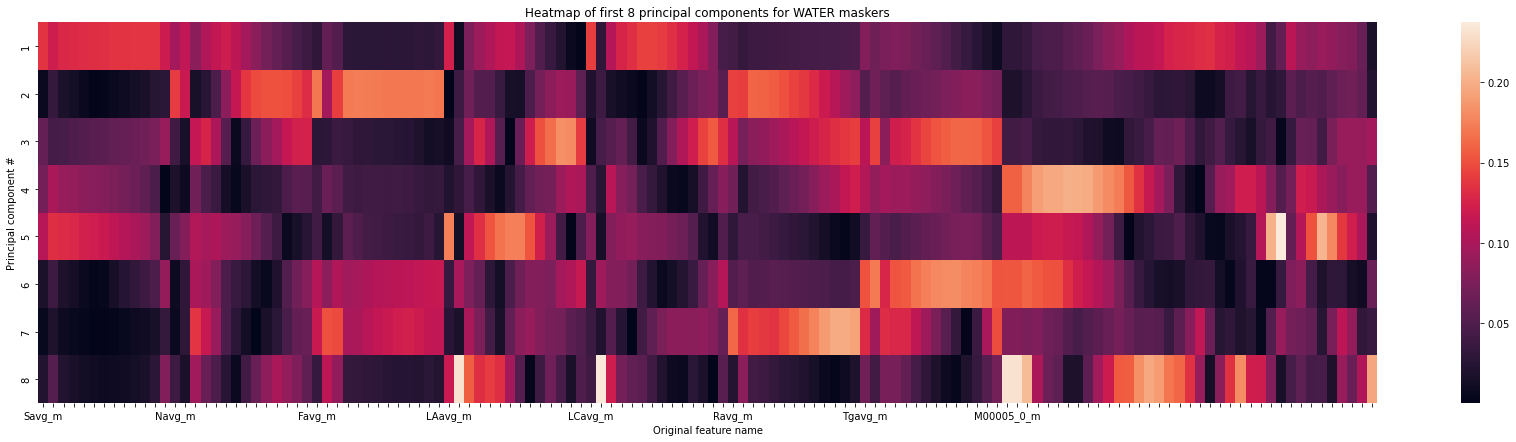

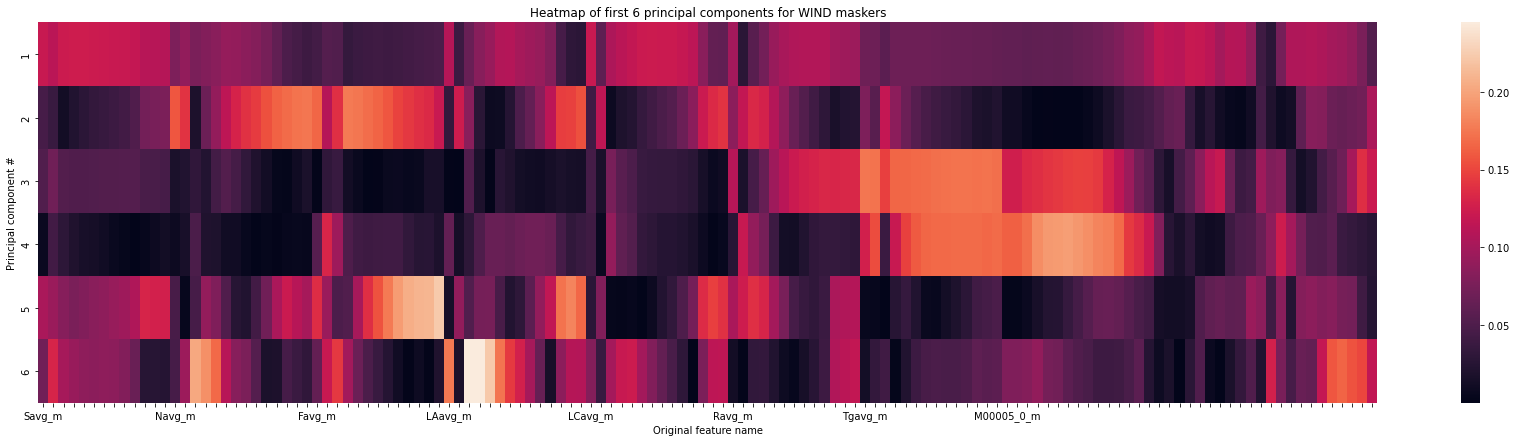

In [26]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = 'normal'

# GENERATE TICK LABELS
xticklabels_m = list(maskers_relevant.iloc[:,84:].columns)
for idx, string in enumerate(xticklabels_m):
    if string not in ['Savg_m','Navg_m','Favg_m','LAavg_m','LCavg_m','Ravg_m','Tgavg_m','M00005_0_m']:
        xticklabels_m[idx] = ''

# PLOT HEATMAPS
for stype, U, k in zip(['BIRD','CONSTRUCTION','TRAFFIC','WATER','WIND'],
                       [Ub, Uc, Ut, Uwa, Uwi],
                        n_components):
    U = U[:k,:]
    yticklabels_m = np.arange(1,k+1)
    plt.figure(figsize=(30,7))
    plt.title(f'Heatmap of first {k} principal components for {stype} maskers')
    sns.heatmap(np.abs(U),xticklabels=xticklabels_m,yticklabels=yticklabels_m)
    plt.xlabel('Original feature name')
    plt.ylabel('Principal component #')
    plt.show()

Expected output of the above block:

<img src="../figures/BIRD_abs.png" height="3000" width="700">
<img src="../figures/CONSTRUCTION_abs.png" height="3000" width="700">
<img src="../figures/TRAFFIC_abs.png" height="3000" width="700">
<img src="../figures/WATER_abs.png" height="3000" width="700">
<img src="../figures/WIND_abs.png" height="3000" width="700">

## Perform SOM clustering

We apply the SOM clustering (here, `SOM` is a helper function that performs the clustering for us) on the truncated PCA-transformed data matrices `Yb` (13 components), `Yc` (9 components), `Yt` (8 components), `Ywa` (8 components), `Ywi` (6 components) to obtain the cluster centres `Wb`, `Wc`, `Wt`, `Wwa`, `Wwi`, respectively. Note that `Db`, `Dc`, `Dt`, `Dwa`, `Dwi` are the distance matrices from the cluster centres to the individual points in the truncated PCA-transformed data matrices.

(On an Intel i5-5257U CPU @ 2.70 GHz with 8GB of RAM, the next block took about 20 seconds to run.).

In [27]:
Db , Wb  = SOM(data = Yb , n1 = 80//5, n2 = 1, eta_SO = 1, eta_Conv = 0.1, seed_val = 2021, verbose = False)
Dc , Wc  = SOM(data = Yc , n1 = 40//5, n2 = 1, eta_SO = 1, eta_Conv = 0.1, seed_val = 2021, verbose = False)
Dt , Wt  = SOM(data = Yt , n1 = 40//5, n2 = 1, eta_SO = 1, eta_Conv = 0.1, seed_val = 2021, verbose = False)
Dwa, Wwa = SOM(data = Ywa, n1 = 80//5, n2 = 1, eta_SO = 1, eta_Conv = 0.1, seed_val = 2021, verbose = False)
Dwi, Wwi = SOM(data = Ywi, n1 = 40//5, n2 = 1, eta_SO = 1, eta_Conv = 0.1, seed_val = 2021, verbose = False)

We visualise the SOM clustering result by plotting the first two principal components of each track and cluster centre on a 2D plot (we haven't sorted the tracks into the actual clusters yet; the plots of the sorted tracks can be found <a href='#Final-plots-m'> below</a>). <a name='Unclustered-plots-m'>

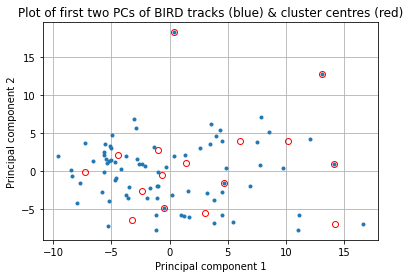

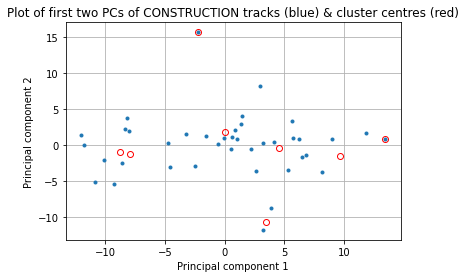

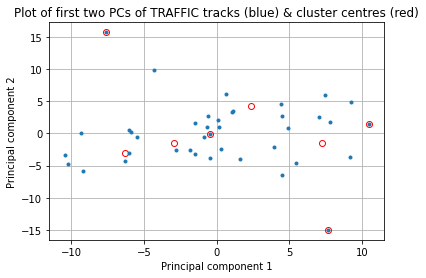

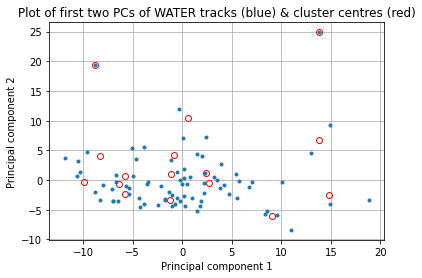

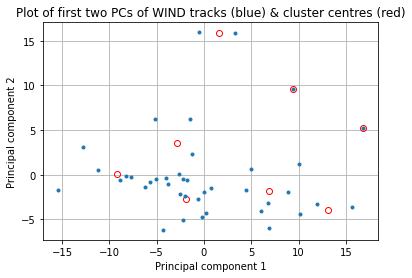

In [28]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = 'normal'

for s, W, Y in zip(['BIRD','CONSTRUCTION','TRAFFIC','WATER','WIND'],
                   [Wb, Wc, Wt, Wwa, Wwi],
                   [Yb, Yc, Yt, Ywa, Ywi]):
    plt.figure()
    plt.title(f'Plot of first two PCs of {s} tracks (blue) & cluster centres (red)')
    plt.plot(W[:,0],W[:,1],'ro',fillstyle='none') # Plot first two principal components of cluster prototype
    plt.plot(Y[:,0],Y[:,1],'.') # Plot first two principal components of each transformed feature matrix
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.grid(which='both',axis='both')
    plt.show()

The graphs generated should be identical to the following five graphs:

<img src="../figures/BIRD_pc.png">
<img src="../figures/CONSTRUCTION_pc.png">
<img src="../figures/TRAFFIC_pc.png">
<img src="../figures/WATER_pc.png">
<img src="../figures/WIND_pc.png">

Assign the tracks into the actual clusters by their distance to the cluster centres. The arrays `Cb`, `Cc`, `Ct`, `Cwa`, `Cwi` returned by `assign_clusters` contain the indices of the clusters for each track.

In [29]:
Cb  = assign_clusters(Db , Wb , m=5)
Cc  = assign_clusters(Dc , Wc , m=5)
Ct  = assign_clusters(Dt , Wt , m=5)
Cwa = assign_clusters(Dwa, Wwa, m=5)
Cwi = assign_clusters(Dwi, Wwi, m=5)

Given the cluster indices, randomly assign each track in a cluster to one of the five folds of the cross-validation set. The arrays `Fb`, `Fc`, `Ft`, `Fwa`, `Fwi` returned by `assign_folds` contain the indices of the folds for each track.

In [30]:
Fb  = assign_folds(Cb )
Fc  = assign_folds(Cc )
Ft  = assign_folds(Ct )
Fwa = assign_folds(Cwa)
Fwi = assign_folds(Cwi)

Plot the first two principal components of each track with a different marker style for each fold. <a name='Final-plots-m'>
   
These are the exact same plots as <a href='#Unclustered-plots-m'> here</a>.

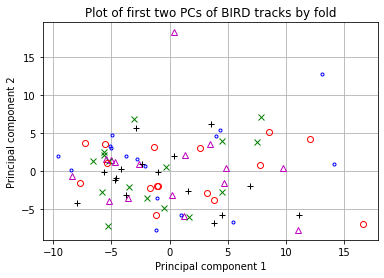

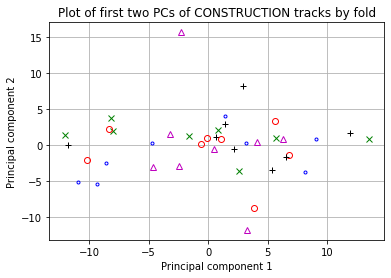

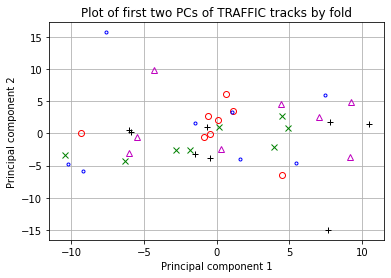

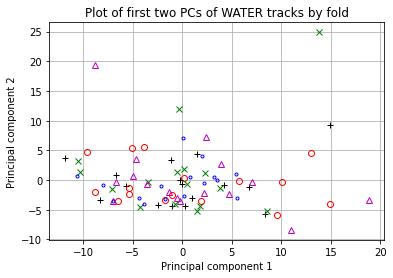

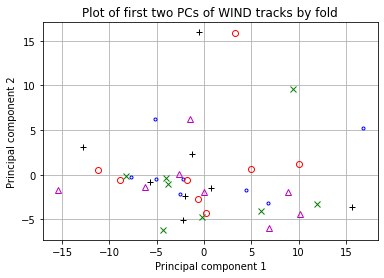

In [31]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = 'normal'

fstrings = ['b.','ro','k+','gx','m^'] # Each string corresponds to a label type for each fold.

for s, Y, F in zip(['BIRD','CONSTRUCTION','TRAFFIC','WATER','WIND'],
                   [Yb, Yc, Yt, Ywa, Ywi],
                   [Fb, Fc, Ft, Fwa, Fwi]):
    plt.figure()
    plt.title(f'Plot of first two PCs of {s} tracks by fold')
    for idx, fold in enumerate(F):
        plt.plot(Y[idx,0],Y[idx,1],fstrings[fold-1], fillstyle='none') # Plot first two principal components of each transformed feature matrix
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.grid(which='both',axis='both')
    plt.show()

The graphs generated should be identical to the following five graphs:

<img src="../figures/BIRD_fold.png">
<img src="../figures/CONSTRUCTION_fold.png">
<img src="../figures/TRAFFIC_fold.png">
<img src="../figures/WATER_fold.png">
<img src="../figures/WIND_fold.png">

Verify that the final folds outputted by the SOM clustering match the fold numbers for the individual maskers in the dataset exactly.

In [32]:
for maskers_type, F in zip([maskers_bird, maskers_construction, maskers_traffic, maskers_water, maskers_wind], [Fb,Fc,Ft,Fwa,Fwi]):
    print(np.all(maskers_type['fold_m'].values == F))

True
True
True
True
True


Expected output of the above block:
```
True
True
True
True
True
```

Note that we never accessed `maskers_type['fold_m']` to perform the PCA or SOM clustering, so the values in `F` were indeed indepdently derived from the PCA and SOM clustering.

# Section 4.1: Analyse affective response questionnaire

## Import relevant packages

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, json

## Load relevant data for analysis

In [34]:
metadata_dir = os.path.join('..','data') # Folder containing all the metadata files; edit as necessary for your system.
maskers = pd.read_csv(os.path.join(f'{metadata_dir}','maskers.csv'))
responses = pd.read_csv(os.path.join(f'{metadata_dir}','responses.csv'), dtype = {'participant':str})

We extract out only the 25440 relevant responses (those that are not attention, calibration or practice stimuli) for analysis.

In [35]:
responses_relevant = responses[responses['fold_r'] != -1]

We first compute the ISO Pleasantness values for each individual response.

In [36]:
attributes = ['pleasant', 'eventful', 'chaotic', 'vibrant', 'uneventful', 'calm', 'annoying', 'monotonous'] # Define attributes to extract from dataframes
ISOPl_weights = [1,0,-np.sqrt(2)/2,np.sqrt(2)/2, 0, np.sqrt(2)/2,-1,-np.sqrt(2)/2] # Define weights for each attribute in attributes in computation of ISO Pleasantness
ISOPls = ((responses_relevant[attributes] * ISOPl_weights).sum(axis=1)/(4+np.sqrt(32))).values

if 'ISOPl' not in responses_relevant.columns:
    responses_relevant.insert(loc=responses_relevant.shape[1],column='ISOPl',value=ISOPls)

Then, we aggregate the mean changes (="deltas") in ISO Pleasantness values for each masker, over the soundscapes it was added to at the various soundscape-to-masker ratios. We also note down the masker class because we will be plotting the changes by masker class later. However, we omit responses where the masker is silence because there is no change to the ISO Pleasantness value if silence was added.

In [37]:
ISOPls_df = responses_relevant.groupby(['soundscape','masker']).mean()['ISOPl'].to_frame().join(maskers.set_index('masker')['class']).reset_index('masker')
ISOPls_by_soundscape = ISOPls_df.join(ISOPls_df[ISOPls_df['class'] == 'silence'], lsuffix = '', rsuffix = '_ref')
ISOPls_by_soundscape['ISOPl_delta'] = ISOPls_by_soundscape['ISOPl']-ISOPls_by_soundscape['ISOPl_ref']
ISOPls_by_masker = ISOPls_by_soundscape.groupby(['masker','class']).mean().sort_values('ISOPl_delta').reset_index()
ISOPls_by_masker = ISOPls_by_masker[ISOPls_by_masker['class'] != 'silence'].reset_index(drop=True)

Lastly, we plot the mean changes in ISO Pleasantness for each masker.

Plots of ISO Pleasantness deltas by masker:


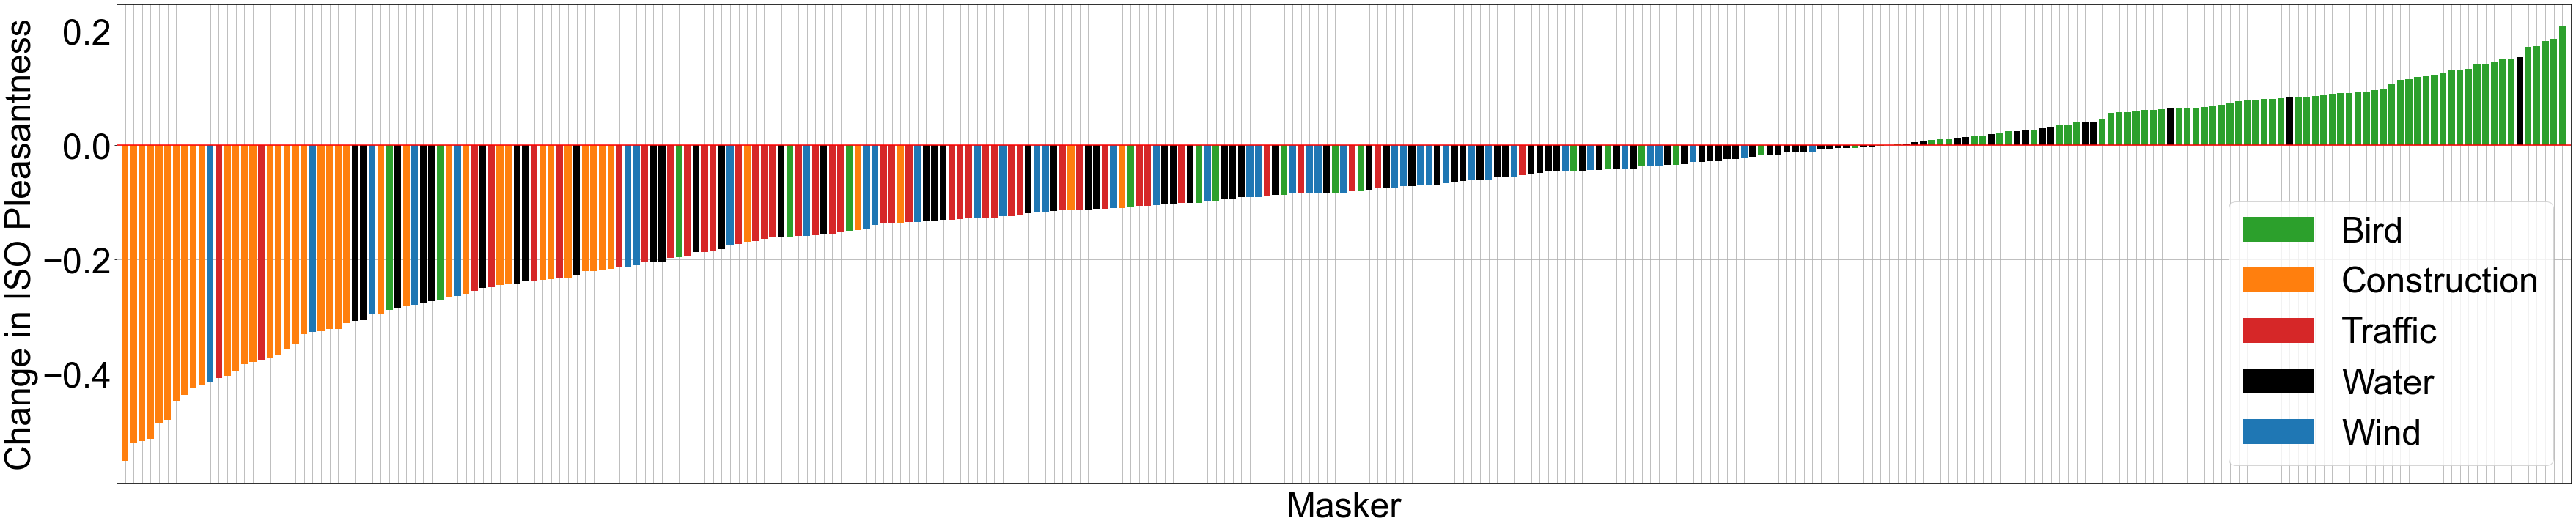

In [38]:
print("Plots of ISO Pleasantness deltas by masker:")
plt.rcParams['font.size'] = 48
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['hatch.linewidth'] = 1.0

fig, ax = plt.subplots(figsize=(60,12))
xlabels = [tup[0].split('.')[0] for tup in ISOPls_by_masker['masker'].tolist()]

y = ISOPls_by_masker['ISOPl_delta'].values
x = np.arange(len(y))
ax.set_xlim(-1,len(x))
for masker_class, color in zip(['bird','construction','traffic','water','wind'],
                               ['#2CA02C','#FF7F0E','#D62728','#000000','#1F77B4']):#'#9467BD']):
    ax.bar(x[ISOPls_by_masker['class'] == masker_class],y[ISOPls_by_masker['class'] == masker_class], label = masker_class.capitalize(), color = color)
ax.set_xlabel('Masker')
ax.set_ylabel('Change in ISO Pleasantness')

ax.set_xticks(ticks = x,labelbottom=False,bottom=False,top=False)
ax.tick_params(bottom=False)
ax.set_xticklabels(labels = '')
ax.set_axisbelow(True)
ax.grid(which='both')
ax.hlines(0,-1,len(x),'r')
ax.legend()
plt.show()

Expected output of the above block:
<img src="../figures/isopl_delta.png">

# Section 4.2: Analyse participant information questionnaire

## Import relevant packages

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import kruskal, chisquare
from araus_utils import plot_continuous_participant_info, plot_categorical_participant_info

p_star = lambda p, thresholds = [0.05, 0.01, 0.001]: '*'*sum([p < t for t in thresholds]) # Prints as many asterisks as number of thresholds crossed.

## Load data file for participants

In [40]:
participants = pd.read_csv(os.path.join('..','data','participants.csv'), dtype = {'participant':str})

## Continuous numerical data.

Do Kruskal-Wallis tests for continuous numerical data.

In [41]:
print("Results of Kruskal-Wallis tests for relevant participant information by fold:")
print("key            | H-val. | p-val.")
print("---------------+--------+-------")
for key in ['age','annoyance_freq','quality','wnss','pss','who','panas_pos','panas_neg']:
    K = kruskal(*[participants[participants['fold_p'] == i][key] for i in range(1,6)]) # A list of series of equal length for which the Kruskal-Wallis test is to be performed on. Each series is one sample.
    print(f'{key:14} | {K.statistic:.4f} | {K.pvalue:.4f} {p_star(K.pvalue)}')

Results of Kruskal-Wallis tests for relevant participant information by fold:
key            | H-val. | p-val.
---------------+--------+-------
age            | 1.6519 | 0.7994 
annoyance_freq | 3.2587 | 0.5155 
quality        | 4.7949 | 0.3090 
wnss           | 2.3861 | 0.6651 
pss            | 1.1454 | 0.8870 
who            | 2.7427 | 0.6018 
panas_pos      | 2.0961 | 0.7181 
panas_neg      | 1.2815 | 0.8645 


Expected output of the above block:
```
Results of Kruskal-Wallis tests for relevant participant information by fold:
key            | H-val. | p-val.
---------------+--------+-------
age            | 1.6519 | 0.7994 
annoyance_freq | 3.2587 | 0.5155 
quality        | 4.7949 | 0.3090 
wnss           | 2.3861 | 0.6651 
pss            | 1.1454 | 0.8870 
who            | 2.7427 | 0.6018 
panas_pos      | 2.0961 | 0.7181 
panas_neg      | 1.2815 | 0.8645 
```

Make violin plots for continuous numerical data.

Plots of participants' demographic information (continuous) by fold:


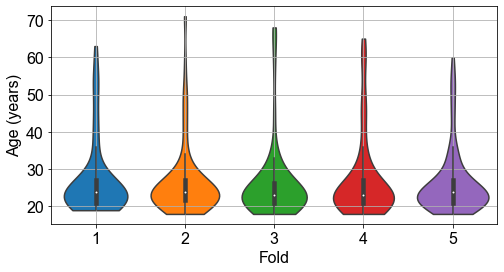

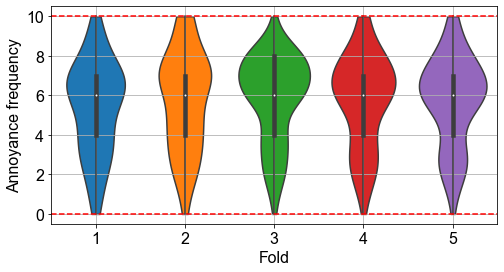

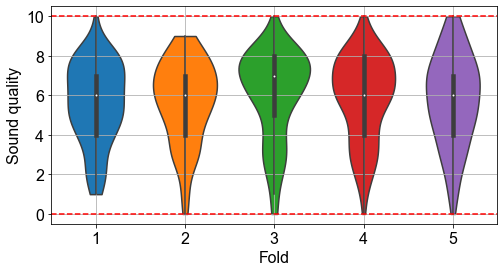

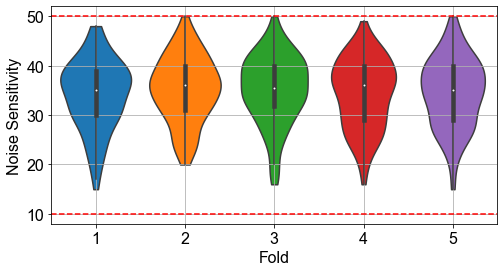

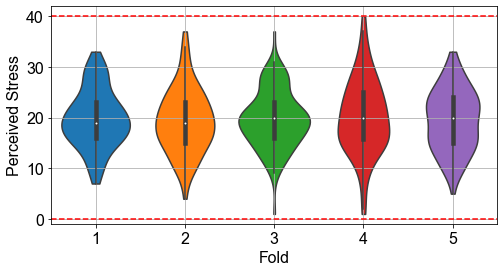

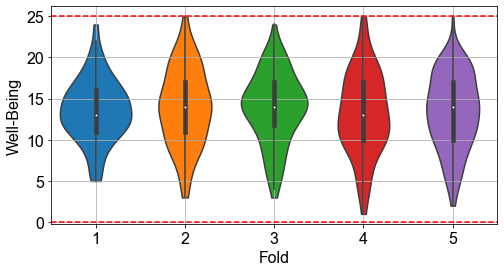

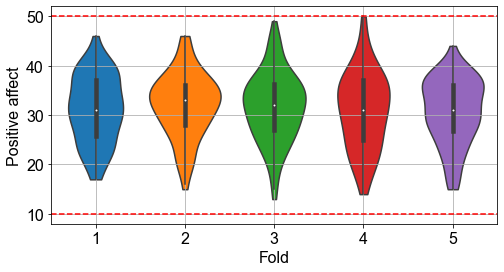

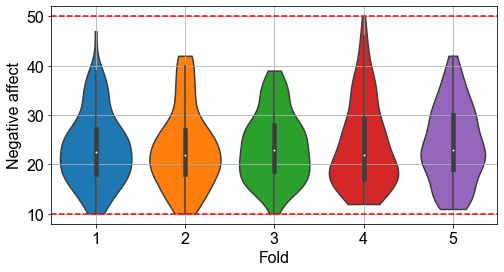

In [42]:
print("Plots of participants' demographic information (continuous) by fold:")
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'

plot_continuous_participant_info(participants, save_to_file=False)

Expected output of the above block:

<img src="../figures/demographic_age.png">
<img src="../figures/demographic_annoyance_freq.png">
<img src="../figures/demographic_quality.png">
<img src="../figures/demographic_wnss.png">
<img src="../figures/demographic_pss.png">
<img src="../figures/demographic_who.png">
<img src="../figures/demographic_panas_pos.png">
<img src="../figures/demographic_panas_neg.png">

## Discrete (categorical) data

Do $\chi^2$-tests (for equality of distributions) for categorical data.

In [43]:
print("Results of chi-squared tests for relevant participant information by fold:")
print("key              | fold | X-val. | p-val.")
print("-----------------+------+--------+-------")
for attribute in ['language_a','language_b','language_c','gender','ethnic','occupation','education_a','education_b','dwelling','citizen','residence_length']:
    for fold in range(1,6):
        # GET OBSERVED COUNTS FOR CURRENT FOLD
        obs_counts = participants[participants['fold_p'] == fold][attribute].value_counts().sort_index()

        # GET EXPECTED COUNTS FOR CURRENT FOLD
        exp_counts = participants[participants['fold_p'] != 0][attribute].value_counts().sort_index() # The expected distribution is the joint distribution of all folds
        exp_counts = (exp_counts*obs_counts.sum()/exp_counts.sum()) # Normalise raw_counts s.t. sum is equal to sum of obs_counts

        # ADD IN ZERO VALUES FOR KEYS WITH ZERO FREQUENCY IN OBSERVED COUNTS
        for key in exp_counts.keys():
            if key not in obs_counts.keys():
                obs_counts[key] = 0
        obs_counts.sort_index(inplace=True)

        CHISQ = chisquare(obs_counts,exp_counts)
        print(f'{attribute:16} | {fold:^4d} | {CHISQ.statistic:.4f} | {CHISQ.pvalue:.4f} {p_star(CHISQ.pvalue)}')

Results of chi-squared tests for relevant participant information by fold:
key              | fold | X-val. | p-val.
-----------------+------+--------+-------
language_a       |  1   | 0.2443 | 0.6211 
language_a       |  2   | 0.0153 | 0.9017 
language_a       |  3   | 0.1870 | 0.6654 
language_a       |  4   | 0.0153 | 0.9017 
language_a       |  5   | 0.0344 | 0.8530 
language_b       |  1   | 0.3707 | 0.8308 
language_b       |  2   | 1.9425 | 0.3786 
language_b       |  3   | 1.3122 | 0.5189 
language_b       |  4   | 0.6725 | 0.7145 
language_b       |  5   | 1.6799 | 0.4317 
language_c       |  1   | 1.3885 | 0.4995 
language_c       |  2   | 0.6943 | 0.7067 
language_c       |  3   | 0.4855 | 0.7845 
language_c       |  4   | 0.5547 | 0.7578 
language_c       |  5   | 0.2225 | 0.8947 
gender           |  1   | 0.2630 | 0.6081 
gender           |  2   | 2.5980 | 0.1070 
gender           |  3   | 0.5918 | 0.4417 
gender           |  4   | 0.3435 | 0.5578 
gender           |  5   

Exptected output of the above block:
```
Results of chi-squared tests for relevant participant information by fold:
key              | fold | X-val. | p-val.
-----------------+------+--------+-------
language_a       |  1   | 0.2443 | 0.6211 
language_a       |  2   | 0.0153 | 0.9017 
language_a       |  3   | 0.1870 | 0.6654 
language_a       |  4   | 0.0153 | 0.9017 
language_a       |  5   | 0.0344 | 0.8530 
language_b       |  1   | 0.3707 | 0.8308 
language_b       |  2   | 1.9425 | 0.3786 
language_b       |  3   | 1.3122 | 0.5189 
language_b       |  4   | 0.6725 | 0.7145 
language_b       |  5   | 1.6799 | 0.4317 
language_c       |  1   | 1.3885 | 0.4995 
language_c       |  2   | 0.6943 | 0.7067 
language_c       |  3   | 0.4855 | 0.7845 
language_c       |  4   | 0.5547 | 0.7578 
language_c       |  5   | 0.2225 | 0.8947 
gender           |  1   | 0.2630 | 0.6081 
gender           |  2   | 2.5980 | 0.1070 
gender           |  3   | 0.5918 | 0.4417 
gender           |  4   | 0.3435 | 0.5578 
gender           |  5   | 0.5918 | 0.4417 
ethnic           |  1   | 1.0508 | 0.7890 
ethnic           |  2   | 3.5286 | 0.3171 
ethnic           |  3   | 0.6204 | 0.8917 
ethnic           |  4   | 0.9676 | 0.8091 
ethnic           |  5   | 2.6249 | 0.4531 
occupation       |  1   | 3.0213 | 0.5543 
occupation       |  2   | 3.3845 | 0.4957 
occupation       |  3   | 5.3639 | 0.2520 
occupation       |  4   | 2.8398 | 0.5850 
occupation       |  5   | 0.8643 | 0.9296 
education_a      |  1   | 3.8880 | 0.6918 
education_a      |  2   | 1.5046 | 0.9592 
education_a      |  3   | 3.7658 | 0.7083 
education_a      |  4   | 1.7228 | 0.9433 
education_a      |  5   | 2.9474 | 0.8154 
education_b      |  1   | 2.1174 | 0.8327 
education_b      |  2   | 0.6463 | 0.9858 
education_b      |  3   | 5.0025 | 0.4156 
education_b      |  4   | 2.5056 | 0.7756 
education_b      |  5   | 4.2588 | 0.5128 
dwelling         |  1   | 3.1992 | 0.3619 
dwelling         |  2   | 0.7510 | 0.8612 
dwelling         |  3   | 2.9759 | 0.3954 
dwelling         |  4   | 1.5848 | 0.6628 
dwelling         |  5   | 1.0186 | 0.7968 
citizen          |  1   | 0.0829 | 0.7734 
citizen          |  2   | 1.3259 | 0.2495 
citizen          |  3   | 1.3259 | 0.2495 
citizen          |  4   | 2.3152 | 0.1281 
citizen          |  5   | 0.2435 | 0.6217 
residence_length |  1   | 0.0300 | 0.8626 
residence_length |  2   | 0.0674 | 0.7951 
residence_length |  3   | 1.7997 | 0.1798 
residence_length |  4   | 1.0787 | 0.2990 
residence_length |  5   | 0.1517 | 0.6969 
```

Make stacked bar plots for discrete categorical data.

Plots of participants' demographic information (categorical) by fold:


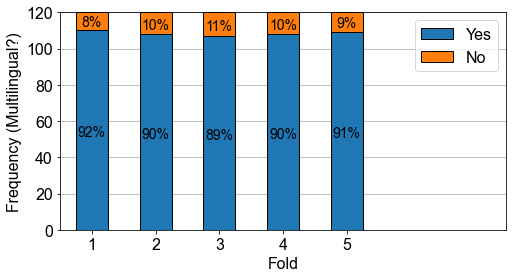

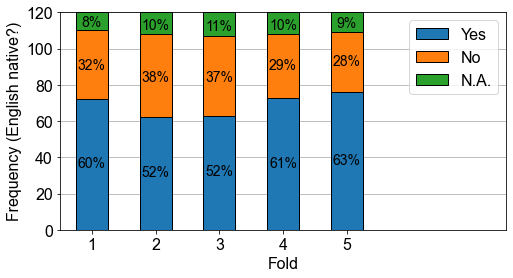

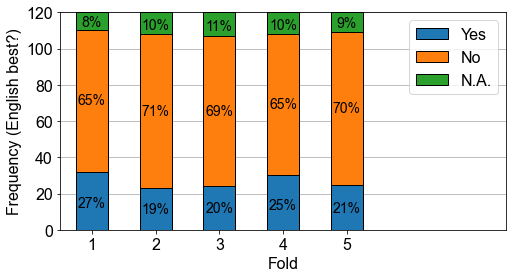

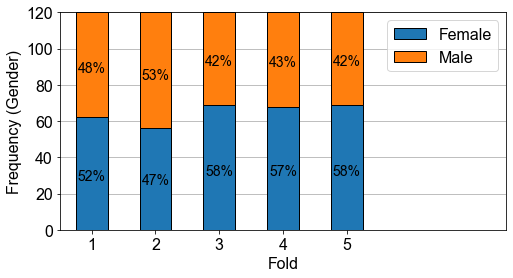

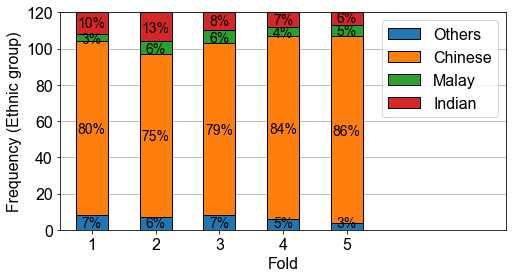

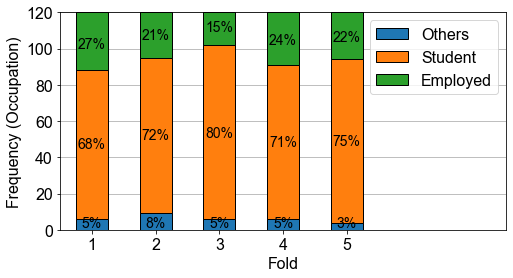

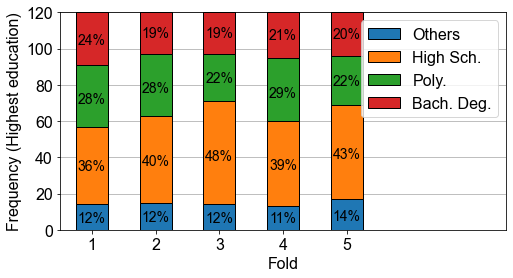

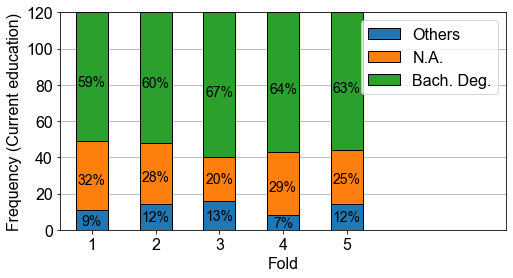

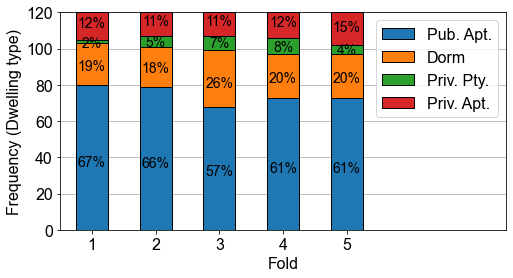

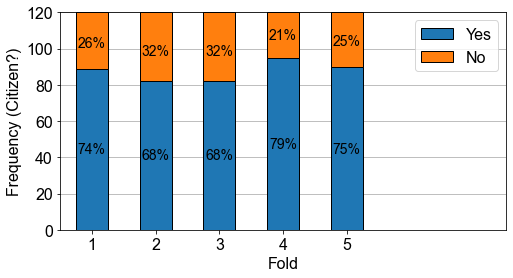

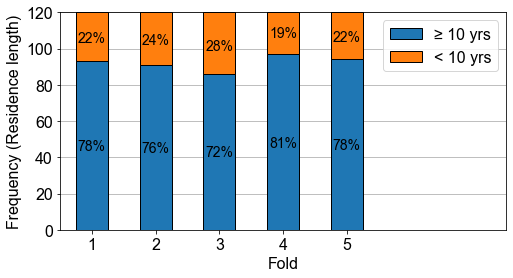

In [44]:
print("Plots of participants' demographic information (categorical) by fold:")
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'

plot_categorical_participant_info(participants, save_to_file=False)

Expected output of the above block:

<img src="../figures/demographic_language_a.png">
<img src="../figures/demographic_language_b.png">
<img src="../figures/demographic_language_c.png">
<img src="../figures/demographic_gender.png">
<img src="../figures/demographic_ethnic.png">
<img src="../figures/demographic_occupation.png">
<img src="../figures/demographic_education_a.png">
<img src="../figures/demographic_education_b.png">
<img src="../figures/demographic_dwelling.png">
<img src="../figures/demographic_citizen.png">
<img src="../figures/demographic_residence_length.png">

# Section 4.3: Analyse consistency checks

## Import relevant packages

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import kruskal
from araus_utils import plot_consistency_metrics, plot_times_taken

p_star = lambda p, thresholds = [0.05, 0.01, 0.001]: '*'*sum([p < t for t in thresholds]) # Prints as many asterisks as number of thresholds crossed.

## Load data files for participants & responses

In [46]:
participants = pd.read_csv(os.path.join('..','data','participants.csv'), dtype = {'participant':str})
responses = pd.read_csv(os.path.join('..','data','responses.csv'), dtype = {'participant':str})

## Consistency checks

We first create a dataframe `consistency` (with participant indices and folds only) that we will add all the consistency metrics to as values.

In [47]:
consistency = participants[['participant','fold_p']].set_index('participant')

We also copy the `responses` dataframe. This is because we will use the `responses` dataframe to compute the consistency metrics, but we will add the values of the consistency metrics as columns to `responses_copy` (instead of `responses`) to prevent changing the original dataframe.

In [48]:
responses_copy = responses.copy()

Get dataframe `first_vs_last` for <b>first</b> consistency metric: Mean absolute deviation between responses on first and last stimulus. We consider a participant to have failed the first consistency check if this is at least 1.

In [49]:
first = responses[(responses['stimulus_index'] == 1) & (responses['fold_r'] == -1)].set_index('participant') # Get first stimulus responses
last = responses[((responses['stimulus_index'] == 45) | (responses['stimulus_index'] == 51)) & (responses['fold_r'] == -1)].set_index('participant') # Get last stimulus responses

attributes = ['pleasant', 'eventful', 'chaotic', 'vibrant', 'uneventful', 'calm', 'annoying', 'monotonous', 'appropriate'] # Define attributes to extract from dataframes
first_vs_last = np.abs(last[attributes]-first[attributes]).mean(axis=1).to_frame('first_vs_last') # Extract attributes and get the mean absolute difference between them

consistency = consistency.join(first_vs_last) # Add it as a column to the consistency dataframe

Get dataframe for <b> second</b> to <b>fifth</b> consistency metrics: Mean absolute deviations between a given attribute and its reverse-coded opposite across all stimuli experienced by the participant. We consider a participant to have failed any of these consistency checks if these values are at least 1.

(There are four such pairs and hence four such checks: Pleasant vs annoying, eventful vs uneventful, calm vs chaotic, vibrant vs monotonous)

In [50]:
labels_a = ['pleasant','eventful','calm','vibrant'] # First attribute of each pair
labels_b = ['annoying','uneventful','chaotic','monotonous'] # Second attribute of each pair

for label_a, label_b in zip(labels_a, labels_b):
    responses_copy[f'{label_a}_vs_{label_b}'] = np.abs(6-responses[label_a]-responses[label_b]) # Get absolute difference between the first and the reverse-coded second attribute (recall that both are in {1,2,3,4,5})
    att_vs_revatt = responses_copy[responses_copy['is_attention'] == 0].groupby(by='participant').mean()[f'{label_a}_vs_{label_b}'].to_frame(f'{label_a}_vs_{label_b}') # Get mean absolute difference across all but attention stimuli (because attention stimuli has fixed answers)
    consistency = consistency.join(att_vs_revatt) # Add it as a column to the consistency dataframe

Get dataframe for <b>sixth</b> and <b>seventh</b> consistency metrics: Mean squared errors between the ISO Pleasantness/Eventfulness values (rescaled to the range [1,5]) and the given pleasantness/eventfulness ratings across all stimuli experienced by the participant. We consider a participant to have failed either of these consistency checks if the value is at least 1.

In [51]:
ISOPl_weights = [1,0,-np.sqrt(2)/2,np.sqrt(2)/2, 0, np.sqrt(2)/2,-1,-np.sqrt(2)/2,0] # Define weights for each attribute in attributes in computation of ISO Pleasantness (last is 0 because it's appropriateness)
ISOPl = 3+(responses[attributes] * ISOPl_weights).sum(axis=1)*2/(4+np.sqrt(32)) # Rescale ISO Pleasantness values to the closed interval [1,5]
responses_copy['ISOPl_vs_pl'] = (ISOPl-responses['pleasant'])**2 # Compute MSE
ISOPl_vs_pl = responses_copy[responses_copy['is_attention'] == 0].groupby(by='participant').mean()['ISOPl_vs_pl'].to_frame('ISOPl_vs_pl')
consistency = consistency.join(ISOPl_vs_pl)

ISOEv_weights = [0,1, np.sqrt(2)/2,np.sqrt(2)/2,-1,-np.sqrt(2)/2, 0,-np.sqrt(2)/2,0] # Define weights for each attribute in attributes in computation of ISO Eventfulness (last is 0 because it's appropriateness)
ISOEv = 3+(responses[attributes] * ISOEv_weights).sum(axis=1)*2/(4+np.sqrt(32)) # Rescale ISO Eventfulness values to the closed interval [1,5]
responses_copy['ISOEv_vs_ev'] = (ISOEv-responses['eventful'])**2 # Compute MSE
ISOEv_vs_ev = responses_copy[responses_copy['is_attention'] == 0].groupby(by='participant').mean()['ISOEv_vs_ev'].to_frame('ISOEv_vs_ev')
consistency = consistency.join(ISOEv_vs_ev)

The dataframe `consistency` now has the seven consistency metrics for the seven consistency checks:

In [52]:
consistency

,fold_p,first_vs_last,pleasant_vs_annoying,eventful_vs_uneventful,calm_vs_chaotic,vibrant_vs_monotonous,ISOPl_vs_pl,ISOEv_vs_ev
participant,,,,,,,,
ARAUS_00001,1,0.555556,0.522727,0.590909,0.500000,0.568182,0.428746,0.630661
ARAUS_00002,2,0.666667,1.113636,0.590909,1.272727,1.250000,0.709554,0.194205
ARAUS_00003,3,0.111111,0.318182,0.340909,0.931818,1.477273,0.204354,0.181305
ARAUS_00004,4,0.555556,0.477273,0.204545,0.659091,0.840909,0.293971,0.265476
ARAUS_00005,5,0.333333,0.590909,0.454545,0.704545,0.727273,0.202835,0.452517
...,...,...,...,...,...,...,...,...
ARAUS_10001,0,0.444444,0.420000,0.280000,0.820000,1.120000,0.204281,0.516382
ARAUS_10002,0,0.333333,0.480000,0.460000,0.340000,0.720000,0.351012,0.257956
ARAUS_10003,0,0.333333,0.200000,0.440000,0.400000,0.740000,0.242174,0.292296


Expected output of the above block:

We verify that all participants failed at most 3 of the consistency checks:

In [53]:
np.all((consistency[['first_vs_last','pleasant_vs_annoying','eventful_vs_uneventful','calm_vs_chaotic','vibrant_vs_monotonous','ISOPl_vs_pl','ISOEv_vs_ev']] >= 1).sum(axis=1) <= 3)

True

Exptected output of the above block:
```
True
```

Do Kruskal-Wallis tests for consistency checks:

In [54]:
print("Results of Kruskal-Wallis tests for participants' consistency checks by fold:")
print("key                    | H-val. | p-val.")
print("-----------------------+--------+-------")
for key in ['first_vs_last','pleasant_vs_annoying','eventful_vs_uneventful','calm_vs_chaotic','vibrant_vs_monotonous','ISOPl_vs_pl','ISOEv_vs_ev']:
    K = kruskal(*[consistency[consistency['fold_p'] == i][key] for i in range(1,6)]) # A list of series of equal length for which the Kruskal-Wallis test is to be performed on. Each series is one sample.
    print(f'{key:22} | {K.statistic:.4f} | {K.pvalue:.4f} {p_star(K.pvalue)}')

Results of Kruskal-Wallis tests for participants' consistency checks by fold:
key                    | H-val. | p-val.
-----------------------+--------+-------
first_vs_last          | 1.7164 | 0.7877 
pleasant_vs_annoying   | 5.0281 | 0.2844 
eventful_vs_uneventful | 5.1821 | 0.2691 
calm_vs_chaotic        | 1.8261 | 0.7677 
vibrant_vs_monotonous  | 5.3364 | 0.2545 
ISOPl_vs_pl            | 1.3751 | 0.8485 
ISOEv_vs_ev            | 4.8070 | 0.3077 


Expected output of the above block:
```
Results of Kruskal-Wallis tests for participants' consistency checks by fold:
key                    | H-val. | p-val.
-----------------------+--------+-------
first_vs_last          | 1.7164 | 0.7877 
pleasant_vs_annoying   | 5.0281 | 0.2844 
eventful_vs_uneventful | 5.1821 | 0.2691 
calm_vs_chaotic        | 1.8261 | 0.7677 
vibrant_vs_monotonous  | 5.3364 | 0.2545 
ISOPl_vs_pl            | 1.3749 | 0.8485 
ISOEv_vs_ev            | 4.8070 | 0.3077 
```

Make violin plots for consistency metrics:

Plots of consistency metrics by fold:


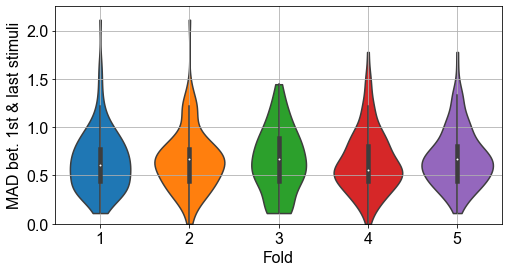

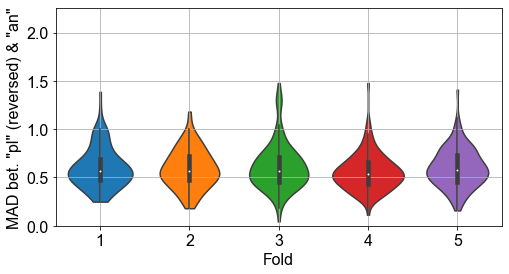

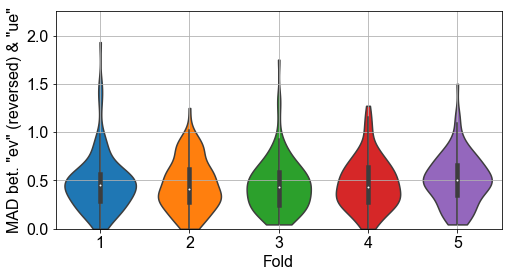

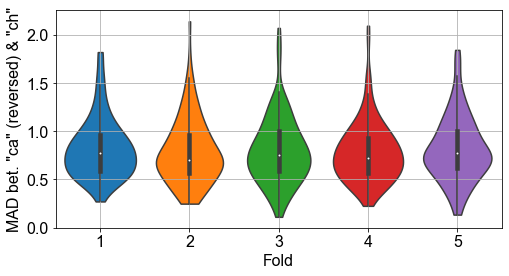

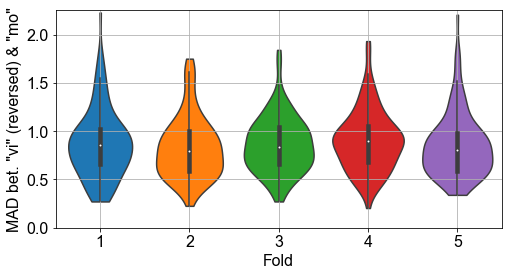

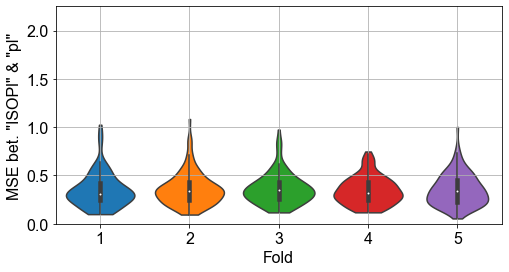

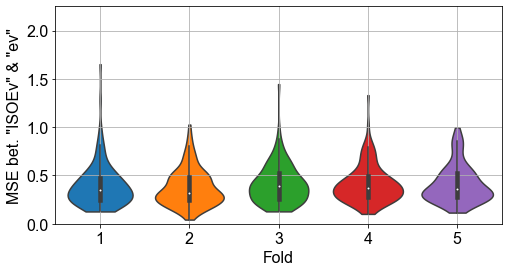

In [55]:
print("Plots of consistency metrics by fold:")
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'

plot_consistency_metrics(consistency, save_to_file = False)

Expected output of the above block:

<img src="../figures/consistency_first_vs_last.png">
<img src="../figures/consistency_pleasant_vs_annoying.png">
<img src="../figures/consistency_eventful_vs_uneventful.png">
<img src="../figures/consistency_calm_vs_chaotic.png">
<img src="../figures/consistency_vibrant_vs_monotonous.png">
<img src="../figures/consistency_ISOPl_vs_pl.png">
<img src="../figures/consistency_ISOEv_vs_ev.png">

## Duration check

For reference, we also perform a Kruskal-Wallis test for the mean time taken by each participant per stimulus by fold.

In [56]:
times = participants.set_index('participant').join(responses.groupby('participant').mean()['time_taken']) # Get mean times taken

print("Results of Kruskal-Wallis tests for participants' consistency checks by fold:")
print("key        | H-val. | p-val.")
print("-----------+--------+-------")
K = kruskal(*[times[times['fold_p'] == i]['time_taken'] for i in range(1,6)]) # A list of series of equal length for which the Kruskal-Wallis test is to be performed on. Each series is one sample.
print(f'time_taken | {K.statistic:.4f} | {K.pvalue:.4f} {p_star(K.pvalue)}')

Results of Kruskal-Wallis tests for participants' consistency checks by fold:
key        | H-val. | p-val.
-----------+--------+-------
time_taken | 1.9695 | 0.7414 


Expected output of the above block:
```
Results of Kruskal-Wallis tests for participants' consistency checks by fold:
key        | H-val. | p-val.
-----------+--------+-------
time_taken | 1.9695 | 0.7414 
```

We also make a violin plot of the mean time taken by each participant per stimulus, by fold.

Plot of mean time taken per stimulus by fold:


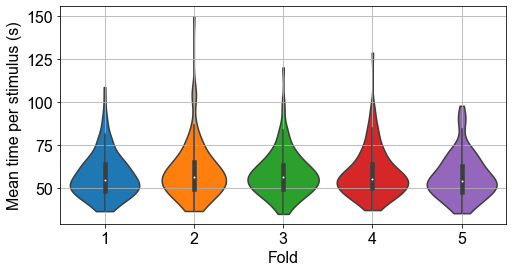

In [57]:
print("Plot of mean time taken per stimulus by fold:")
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'

plot_times_taken(times, save_to_file=False)

Expected output of the above block:

<img src="../figures/times_taken.png">

# Section 5.1.1: Baseline models (Label mean, elastic net)

For the baseline models, we aim to predict the normalised ISO Pleasantness values (computed according to the circumplex model in ISO12913-3) for each of the responses provided by the participants. Hence, the ISO Pleasantness values computed for each stimulus are the ground-truth labels for each stimulus. These are values in the closed interval [-1,1].

## Import relevant packages

In [58]:
import sklearn.linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

clip = lambda x, x_min = -1, x_max = 1: np.where(np.where(x < x_min,x_min,x) > x_max, x_max, np.where(x < x_min,x_min,x)) # Clip an array to values between x_min and x_max.

## Load data files for responses

In [59]:
responses = pd.read_csv(os.path.join('..','data','responses.csv'), dtype = {'participant':str})

## Generate ground-truth labels

Firstly, we compute all the ground-truth labels and add them to the `responses` dataframe.

In [60]:
attributes = ['pleasant', 'eventful', 'chaotic', 'vibrant', 'uneventful', 'calm', 'annoying', 'monotonous'] # Define attributes to extract from dataframes
ISOPl_weights = [1,0,-np.sqrt(2)/2,np.sqrt(2)/2, 0, np.sqrt(2)/2,-1,-np.sqrt(2)/2] # Define weights for each attribute in attributes in computation of ISO Pleasantness

responses_copy = responses.copy() 
responses_copy['ground_truth_label'] = ((responses[attributes] * ISOPl_weights).sum(axis=1)/(4+np.sqrt(32))).values # These are normalised ISO Pleasantness values (in [-1,1])

## Dummy "label mean" model

Now, we compute the relevant metrics for a dummy "label mean" model, which just predicts the mean of the ground-truth labels in its training set no matter the input.

In [61]:
train_mmse = 0
val_mmse = 0
test_mmse = 0
print('     |    Mean squared error    |        |       # samples      ')
print('Fold |--------+--------+--------| Label  |-------+-------+------')
print('     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test ')
print('-----+--------+--------+--------+--------+-------+-------+------')
df_trains = [] # For plotting the distributions of ISO Pleasantness labels in next block
df_vals = [] # For plotting the distributions of ISO Pleasantness labels in next block
for val_fold in [1,2,3,4,5]:
    df_train = responses_copy[(responses_copy['fold_r'] != val_fold) & (responses_copy['fold_r'] > 0)] # For the training set, use all samples that are not in the test set (fold 0) and current validation fold.
    df_val   = responses_copy[responses_copy['fold_r'] == val_fold]
    df_test  = responses_copy[responses_copy['fold_r'] == 0].groupby(['soundscape','masker','smr']).mean() # For the test set, the same 48 stimuli were shown to all participants so we take the mean of their ratings as the ground truth
    df_trains.append(df_train['ground_truth_label'])
    df_vals.append(df_val['ground_truth_label'])
    
    y_hat = df_train['ground_truth_label'].mean() # This will be the label mean model's prediction for all unseen data.
    
    train_mse = ((df_train['ground_truth_label'] - y_hat)**2).mean() # Compute MSE on training set for label mean model
    val_mse   = ((  df_val['ground_truth_label'] - y_hat)**2).mean() # Compute MSE on validation set for label mean model
    test_mse  = (( df_test['ground_truth_label'] - y_hat)**2).mean() # Compute MSE on test set for label mean model
    
    train_mmse += train_mse
    val_mmse += val_mse
    test_mmse += test_mse
    
    print(f'{val_fold:4d} | {train_mse:.4f} | {val_mse:.4f} | {test_mse:.4f} | {y_hat:.4f} | {df_train.shape[0]:5d} | {df_val.shape[0]:5d} | {df_test.shape[0]:^5d}')

print(f'Mean | {train_mmse/5:.4f} | {val_mmse/5:.4f} | {test_mmse/5:.4f}')

     |    Mean squared error    |        |       # samples      
Fold |--------+--------+--------| Label  |-------+-------+------
     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test 
-----+--------+--------+--------+--------+-------+-------+------
   1 | 0.1557 | 0.1532 | 0.1173 | 0.0208 | 20160 |  5040 |  48  
   2 | 0.1563 | 0.1507 | 0.1207 | 0.0317 | 20160 |  5040 |  48  
   3 | 0.1542 | 0.1588 | 0.1204 | 0.0307 | 20160 |  5040 |  48  
   4 | 0.1531 | 0.1631 | 0.1196 | 0.0281 | 20160 |  5040 |  48  
   5 | 0.1562 | 0.1508 | 0.1179 | 0.0225 | 20160 |  5040 |  48  
Mean | 0.1551 | 0.1553 | 0.1192


Expected output of the above block:
```
     |    Mean squared error    |        |       # samples      
Fold |--------+--------+--------| Label  |-------+-------+------
     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test 
-----+--------+--------+--------+--------+-------+-------+------
   1 | 0.1557 | 0.1532 | 0.1173 | 0.0208 | 20160 |  5040 |  48  
   2 | 0.1563 | 0.1507 | 0.1207 | 0.0317 | 20160 |  5040 |  48  
   3 | 0.1542 | 0.1588 | 0.1204 | 0.0307 | 20160 |  5040 |  48  
   4 | 0.1531 | 0.1631 | 0.1196 | 0.0281 | 20160 |  5040 |  48  
   5 | 0.1562 | 0.1508 | 0.1179 | 0.0225 | 20160 |  5040 |  48  
Mean | 0.1551 | 0.1553 | 0.1192
```

As an illustration, we also make violin plots of the distribution of the training and validation sets, by fold used as the validation fold.

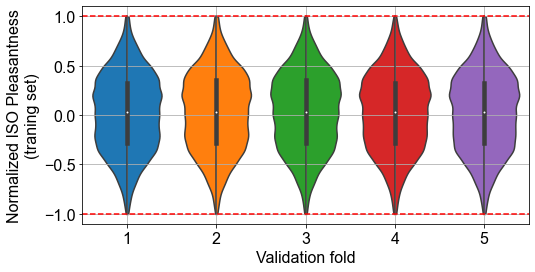

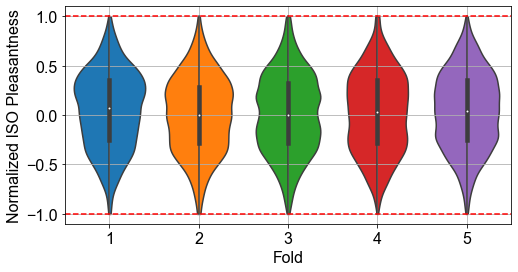

In [62]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.style'] = 'normal'
for df, x_label, y_label in zip([df_trains, df_vals],
                                ['Validation fold','Fold'],
                                ['Normalized ISO Pleasantness\n(traning set)','Normalized ISO Pleasantness']):
    plt.figure(figsize = (8,4))
    sns.violinplot(data = df,
                   saturation = 1,
                   cut = 0)
    plt.xlabel(x_label)
    plt.xticks(ticks = range(0,5), labels = range(1,6))
    plt.ylabel(y_label)
    plt.axhline(-1, color='red', linestyle='--')
    plt.axhline( 1, color='red', linestyle='--')
    plt.grid(visible=True)
    plt.show()

Expected output of the above block:

<img src="../figures/label_means_train.png">
<img src="../figures/label_means_val.png">


## Elastic net model

Lastly, for this section, we train an elastic net model for each fold of the cross-validation set and compute the corresponding metrics. The elastic net model minimises the loss function

$$L(w_1,\dots,w_n) = \sum_{i=1}^{n}\left(\left(y_i-w_ix_i\right)^2 + \alpha\left|w_i\right| + \beta w_i^2\right),$$

where $y_i$ are the ground truth labels, $x_i$ are the input features (or "predictor variables"), $w_i$ are the weights for the individual features (or "coefficients"), $n$ is the number of training samples, and $\alpha,\beta$ are regularisation parameters.

Note that the shapes of the feature arrays in the following block are:
- `X_train`: (20160, 132)
- `Y_train`: (20160,)
- `X_val`: (5040, 132)
- `Y_val`: (5040,)
- `X_test`: (48, 132)
- `Y_test`: (48,)

We first define the predictor variables that we will be using in `relevant_columns_enet`:

In [77]:
relevant_columns_enet = ['Savg_r','Smax_r','S05_r','S10_r','S20_r','S30_r','S40_r','S50_r','S60_r','S70_r','S80_r','S90_r','S95_r',
                         'Navg_r','Nrmc_r','Nmax_r','N05_r','N10_r','N20_r','N30_r','N40_r','N50_r','N60_r','N70_r','N80_r','N90_r','N95_r',
                         'Favg_r','Fmax_r','F05_r','F10_r','F20_r','F30_r','F40_r','F50_r','F60_r','F70_r','F80_r','F90_r','F95_r',
                         'LAavg_r','LAmin_r','LAmax_r','LA05_r','LA10_r','LA20_r','LA30_r','LA40_r','LA50_r','LA60_r','LA70_r','LA80_r','LA90_r','LA95_r',
                         'LCavg_r','LCmin_r','LCmax_r','LC05_r','LC10_r','LC20_r','LC30_r','LC40_r','LC50_r','LC60_r','LC70_r','LC80_r','LC90_r','LC95_r',
                         'Ravg_r','Rmax_r','R05_r','R10_r','R20_r','R30_r','R40_r','R50_r','R60_r','R70_r','R80_r','R90_r','R95_r',
                         'Tgavg_r','Tavg_r','Tmax_r','T05_r','T10_r','T20_r','T30_r','T40_r','T50_r','T60_r','T70_r','T80_r','T90_r','T95_r',
                         'M00005_0_r','M00006_3_r','M00008_0_r','M00010_0_r','M00012_5_r','M00016_0_r','M00020_0_r','M00025_0_r','M00031_5_r','M00040_0_r',
                         'M00050_0_r','M00063_0_r','M00080_0_r','M00100_0_r','M00125_0_r','M00160_0_r','M00200_0_r','M00250_0_r','M00315_0_r','M00400_0_r',
                         'M00500_0_r','M00630_0_r','M00800_0_r','M01000_0_r','M01250_0_r','M01600_0_r','M02000_0_r','M02500_0_r','M03150_0_r','M04000_0_r',
                         'M05000_0_r','M06300_0_r','M08000_0_r','M10000_0_r','M12500_0_r','M16000_0_r','M20000_0_r']

Then, we generate the elastic net models and evaluate their performance:

In [78]:
model = sklearn.linear_model.ElasticNet
print(f'Investigating performance of {model()} model...')
MSEs_train = []
MSEs_val = []
MSEs_test = []

print('     |    Mean squared error    |         |       # samples      | #     | # NZ ')
print('Fold |--------+--------+--------| Inter-  |-------+-------+------| feat- | feat-')
print('     | Train  |   Val  |  Test  |  cept   | Train |  Val  | Test | ures  | ures ')
print('-----+--------+--------+--------+---------+-------+-------+------+-------+------')
for val_fold in [1,2,3,4,5]:

    # Extract dataframes
    df_train = responses_copy[(responses_copy['fold_r'] != val_fold) & (responses_copy['fold_r'] > 0)] # For the training set, use all samples that are not in the test set (fold 0) and current validation fold.
    df_val   = responses_copy[responses_copy['fold_r'] == val_fold]
    df_test  = responses_copy[responses_copy['fold_r'] == 0].groupby(['soundscape','masker','smr']).mean() # For the test set, the same 48 stimuli were shown to all participants so we take the mean of their ratings as the ground truth

    # Get ground-truth labels
    Y_train = df_train['ground_truth_label'].values
    Y_val = df_val['ground_truth_label'].values
    Y_test = df_test['ground_truth_label'].values

    # Get features
    X_train = df_train[relevant_columns_enet].values 
    X_val = df_val[relevant_columns_enet].values
    X_test = df_test[relevant_columns_enet].values        

    # Fit model
    X_LR = model().fit(X_train, Y_train)

    # Get MSEs
    MSE_train = np.mean((X_LR.predict(X_train) - Y_train)**2)
    MSE_val = np.mean((X_LR.predict(X_val) - Y_val)**2)
    MSE_test = np.mean((X_LR.predict(X_test) - Y_test)**2)

    # Add metrics
    MSEs_train.append(MSE_train)
    MSEs_val.append(MSE_val)
    MSEs_test.append(MSE_test)

    print(f'{val_fold:4d} | {MSE_train:.4f} | {MSE_val:.4f} | {MSE_test:.4f} | {X_LR.intercept_:7.4f} | {X_train.shape[0]:5d} | {X_val.shape[0]:5d} | {X_test.shape[0]:^4d} | {X_train.shape[1]:^5d} | {np.sum(np.abs(X_LR.coef_) > 0):^5d}')

print(f'Mean | {np.mean(MSEs_train):.4f} | {np.mean(MSEs_val):.4f} | {np.mean(MSEs_test):.4f}')
print()

Investigating performance of ElasticNet() model...
     |    Mean squared error    |         |       # samples      | #     | # NZ 
Fold |--------+--------+--------| Inter-  |-------+-------+------| feat- | feat-
     | Train  |   Val  |  Test  |  cept   | Train |  Val  | Test | ures  | ures 
-----+--------+--------+--------+---------+-------+-------+------+-------+------
   1 | 0.1360 | 0.1321 | 0.0912 |  0.3074 | 20160 |  5040 |  48  |  132  |   3  
   2 | 0.1368 | 0.1284 | 0.0954 |  0.3105 | 20160 |  5040 |  48  |  132  |   2  
   3 | 0.1351 | 0.1384 | 0.0941 |  0.2898 | 20160 |  5040 |  48  |  132  |   2  
   4 | 0.1329 | 0.1439 | 0.0941 |  0.3070 | 20160 |  5040 |  48  |  132  |   2  
   5 | 0.1349 | 0.1355 | 0.0900 |  0.3029 | 20160 |  5040 |  48  |  132  |   3  
Mean | 0.1351 | 0.1357 | 0.0930



Expected output of the above block:
```
Investigating performance of ElasticNet() model...
     |    Mean squared error    |         |       # samples      | #     | # NZ 
Fold |--------+--------+--------| Inter-  |-------+-------+------| feat- | feat-
     | Train  |   Val  |  Test  |  cept   | Train |  Val  | Test | ures  | ures 
-----+--------+--------+--------+---------+-------+-------+------+-------+------
   1 | 0.1360 | 0.1321 | 0.0912 |  0.3074 | 20160 |  5040 |  48  |  132  |   3  
   2 | 0.1368 | 0.1284 | 0.0954 |  0.3105 | 20160 |  5040 |  48  |  132  |   2  
   3 | 0.1351 | 0.1384 | 0.0941 |  0.2898 | 20160 |  5040 |  48  |  132  |   2  
   4 | 0.1329 | 0.1439 | 0.0941 |  0.3070 | 20160 |  5040 |  48  |  132  |   2  
   5 | 0.1349 | 0.1355 | 0.0900 |  0.3029 | 20160 |  5040 |  48  |  132  |   3  
Mean | 0.1351 | 0.1357 | 0.0930
```

# Section 5.1.2: Baseline model (Convolutional neural network)

Before running this section, please check if you have already downloaded the raw masker and soundscape files, because the features used as input to the deep neural network will be generated from these files. In other words, your directory structure should look something like this:

If you have not downloaded the files, please exit this notebook and run the command

```python download.py```

from the terminal. Otherwise, you should be able to continue running the subsequent blocks without issue.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os, json

from araus_tf import ARAUS_Sequence_from_npy, make_baseline_model, train_model

Check the devices available for training.

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

Load relevant data for training.

In [3]:
metadata_dir = os.path.join('..','data') # Folder containing all the metadata files; edit as necessary for your system.
maskers = pd.read_csv(os.path.join(f'{metadata_dir}','maskers.csv'))
soundscapes = pd.read_csv(os.path.join(f'{metadata_dir}','soundscapes.csv'))
responses = pd.read_csv(os.path.join(f'{metadata_dir}','responses.csv'), dtype = {'participant':str})

Split responses dataframe by fold.

In [4]:
# TEST SET
df_test = responses[(responses['fold_r'] == 0) & (responses['participant'] == 'ARAUS_10001')].set_index(['soundscape','masker','smr'])
test_labels = responses[responses['fold_r'] == 0].groupby(['soundscape','masker','smr']).mean() # Average labels across all test set participants because they were presented with identical stimuli
attributes = ['pleasant', 'eventful', 'chaotic', 'vibrant', 'uneventful', 'calm', 'annoying', 'monotonous']
df_test[attributes] = test_labels[attributes]
df_test.reset_index(inplace=True)

# CROSS-VALIDATION SET
df_xval = [responses[responses['fold_r'] == i] for i in range(1,6)]

# COMBINED CROSS-VALIDATION & TEST SET
df_folds = [df_test]
df_folds.extend(df_xval)

Make and save features to `.npy` files (on an Intel i5-5257U CPU @ 2.70 GHz with 8GB of RAM, the next block took about 2 hours 15 minutes to run).

In [13]:
for idx, df_fold in enumerate(df_folds):
    print(f'Making features for fold #{idx}/{len(df_folds)-1}...')
    ARAUS_Sequence_from_npy(df_fold).precompute(soundscapes,maskers)

Making features for fold #0/5...
Making features for fold #1/5...
Making features for fold #2/5...
Making features for fold #3/5...
Making features for fold #4/5...
Making features for fold #5/5...


Define model architecture (identical to DCASE 2022 Task 1's baseline model at https://github.com/marmoi/dcase2022_task1_baseline).

In [14]:
make_baseline_model().summary()

Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Spec_Input (InputLayer)      [(None, 644, 64, 2)]      0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 644, 64, 16)       1584      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 644, 64, 16)       64        
_________________________________________________________________
Relu_1 (Activation)          (None, 644, 64, 16)       0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 644, 64, 16)       12560     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 644, 64, 16)       64        
_________________________________________________________________
Relu_2 (Activation)          (None, 644, 64, 16)       0  

Expected output of the above block:

```
Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
Spec_Input (InputLayer)      [(None, 644, 64, 2)]      0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 644, 64, 16)       1584      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 644, 64, 16)       64        
_________________________________________________________________
Relu_1 (Activation)          (None, 644, 64, 16)       0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 644, 64, 16)       12560     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 644, 64, 16)       64        
_________________________________________________________________
Relu_2 (Activation)          (None, 644, 64, 16)       0         
_________________________________________________________________
MP2D_2 (MaxPooling2D)        (None, 128, 12, 16)       0         
_________________________________________________________________
Dropout_2 (Dropout)          (None, 128, 12, 16)       0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 128, 12, 32)       25120     
_________________________________________________________________
BN_3 (BatchNormalization)    (None, 128, 12, 32)       128       
_________________________________________________________________
Relu_3 (Activation)          (None, 128, 12, 32)       0         
_________________________________________________________________
MP2D_3 (MaxPooling2D)        (None, 32, 1, 32)         0         
_________________________________________________________________
Dropout_3 (Dropout)          (None, 32, 1, 32)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
Dense (Dense)                (None, 100)               102500    
_________________________________________________________________
Dropout_Dense (Dropout)      (None, 100)               0         
_________________________________________________________________
ISOPl (Dense)                (None, 1)                 101       
=================================================================
Total params: 142,121
Trainable params: 141,993
Non-trainable params: 128
_________________________________________________________________
```

Train the model with the architecture specified in the above block (on an Intel Xeon Gold 6226R CPU @ 2.90 GHz with 128GB of RAM and an NVIDIA Quadro RTX 5000, the next block took about 1 hour 45 minutes to run).

In [15]:
# Positional: df_folds
run = 1
verbose = 0

print(f'Investigating performance of CNN model...')
MSEs_CNN_train = []
MSEs_CNN_val = []
MSEs_CNN_test = []

print('     |    Mean squared error    ')
print('Fold |--------+--------+--------')
print('     | Train  |   Val  |  Test  ')
print('-----+--------+--------+--------')

for val_fold in range(1,6):
    # Get train folds as remaining folds in cross-validation set
    train_folds = [1,2,3,4,5]
    train_folds.remove(val_fold)

    # Make dataframes of responses for train/val/test set
    train_responses = pd.concat([df_folds[train_fold] for train_fold in train_folds])
    val_responses = df_folds[val_fold]
    test_responses = df_folds[0]

    # Make generator Sequences (from tensorflow.keras.utils.Sequence) for train/val/test set
    train_seq = ARAUS_Sequence_from_npy(train_responses, seed_val = run, verbose = verbose)
    val_seq = ARAUS_Sequence_from_npy(val_responses, seed_val = run, shuffle = False, verbose = verbose) # No need to shuffle for val set as result will be same regardless
    test_seq = ARAUS_Sequence_from_npy(test_responses, seed_val = run, shuffle = False, verbose = verbose) # No need to shuffle for test set as result will be same regardless
    
    history, loss_dict = train_model(make_baseline_model(),
                                     train_data = train_seq,
                                     validation_data = val_seq,
                                     test_data = test_seq,
                                     seed = run,
                                     learning_rate = 0.0001,
                                     mtype = 'baseline',
                                     run = run,
                                     val_fold = val_fold,
                                     save_best_only = False,
                                     save_weights_only = True,
                                     patience = 10,
                                     restore_best_weights = True,
                                     batch_size = None,
                                     epochs = 100,
                                     workers = 1,
                                     use_multiprocessing = False,
                                     verbose = verbose)
    
    # Get MSEs
    MSE_CNN_train = history['loss'][np.argmin(history['val_loss'])]
    MSE_CNN_val = np.min(history['val_loss'])
    MSE_CNN_test = loss_dict['loss']
    
    # Add metrics
    MSEs_CNN_train.append(MSE_CNN_train)
    MSEs_CNN_val.append(MSE_CNN_val)
    MSEs_CNN_test.append(MSE_CNN_test)
    
    print(f'{val_fold:4d} | {MSE_CNN_train:.4f} | {MSE_CNN_val:.4f} | {MSE_CNN_test:.4f}')

print(f'Mean | {np.mean(MSEs_CNN_train):.4f} | {np.mean(MSEs_CNN_val):.4f} | {np.mean(MSEs_CNN_test):.4f}')

Investigating performance of CNN model...
     |    Mean squared error    
Fold |--------+--------+--------
     | Train  |   Val  |  Test  
-----+--------+--------+--------
   1 | 0.1232 | 0.1197 | 0.0965
   2 | 0.1151 | 0.1114 | 0.0829
   3 | 0.1164 | 0.1217 | 0.0712
   4 | 0.1124 | 0.1239 | 0.0761
   5 | 0.1170 | 0.1276 | 0.0836
Mean | 0.1168 | 0.1209 | 0.0821


A sample output of the above block is shown below. The exact values may differ depending on your setup and the GPU you are using, but we observed a mean training set MSE of $0.1152 \pm 0.0020$, validation set MSE of $0.1212 \pm 0.0010$, and test set MSE of $0.0865 \pm 0.0063$ (across 10 differently-seeded runs).
```
Investigating performance of CNN model...
     |    Mean squared error    
Fold |--------+--------+--------
     | Train  |   Val  |  Test  
-----+--------+--------+--------
   1 | 0.1261 | 0.1232 | 0.0967
   2 | 0.1124 | 0.1143 | 0.0656
   3 | 0.1062 | 0.1236 | 0.0777
   4 | 0.1095 | 0.1225 | 0.0751
   5 | 0.1238 | 0.1273 | 0.1193
Mean | 0.1156 | 0.1222 | 0.0869
```